### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


### Columns

In [3]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

cols_num = [c for c in cols_num if c not in cols_feats_rm]
cols_bin = [c for c in cols_bin if c not in cols_feats_rm]
cols_cat = [c for c in cols_cat if c not in cols_feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add))

Num: 155 Bin: 49 Cat: 7
Add: 1 0 1


### Read data

In [4]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,9,1,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,88,1,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,113,1,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,23,1,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,75,1,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061


shape = (60000, 235)


### Preprocessing

In [5]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
     return df

In [6]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)
    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
    return y_pred_final

In [7]:
df = pre_processing(df, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if df[c].skew() > 2.2]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_

### Feature engineering
Include cat encoding, fillna, scaling

In [9]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [13]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df):
        df = df.copy()    
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [30]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

keras: 2.2.2 tensorflow: 1.10.1


In [29]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate
from keras.optimizers import Adam, SGD

from keras_get_best import GetBest

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [54]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(512,)*10, learning_rate=0.001, optimizer=Adam):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for n in n_neurons:
        x_layer = Dense(n, activation='relu')(x_layer)
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    model.compile(optimizer=optimizer(lr=learning_rate), loss='mae', metrics=['mse'])
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for i, hist in enumerate(hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+str(i), alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

#### One run testing

In [34]:
from sklearn.model_selection import train_test_split
itrain, ival = train_test_split(dfp.index, test_size=0.3, random_state=123)

# split train, val
df_train = df.loc[itrain].reset_index(drop=True)
df_val = df.loc[ival].reset_index(drop=True)

# feat eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,)
df_train = feat_eng.fit_transform(df_train)
df_val = feat_eng.transform(df_val)

In [35]:
df_train.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,quarter_txn_dt,year_txn_dt,dow_building_complete_dt,day_in_year_building_complete_dt,month_building_complete_dt,quarter_building_complete_dt,year_building_complete_dt,dt_diff_building_complete_dt_txn_dt,land_per_building_area,log_per_area_total_price_scaled
0,T1JoS1XWqso1c9G0,6,8,-1.291672,1.252125,1,3,0.722059,1,-0.233173,...,3,50,3,315,10,3,38,4370.0,-0.613060,1.491160
1,UMyDRljT7Ze4l3eJ,6,7,-1.685994,-0.519756,4,3,1.310622,3,-0.233173,...,0,50,5,317,10,3,45,1527.0,1.100474,-1.202731
2,mTdaS1xzULNW1Ubm,6,4,-1.492969,2.630255,1,3,0.932211,1,-0.233173,...,1,50,6,133,4,1,41,3311.0,-2.214306,0.155702
3,D1bHnOx451bxG5R7,6,4,0.572396,-0.716632,3,3,-1.288767,3,-0.233173,...,2,54,3,339,11,3,14,14458.0,1.177113,0.716418
4,WyxmUEFOTLygBMgo,6,11,-0.931819,-0.716632,5,3,-0.055478,3,-0.233173,...,2,51,6,222,7,2,29,8009.0,0.355260,-2.034560
41995,QQ3yQPoujssJczPs,6,9,-1.523302,-0.519756,5,2,0.252728,3,-0.233173,...,1,50,1,101,3,1,33,6241.0,-0.505959,-0.774163
41996,rM5ZZL8I50csvris,1,6,-0.423060,-1.110384,5,3,-1.113602,3,-0.233173,...,2,52,1,5,0,0,17,12975.0,1.290049,-1.208087
41997,A89t9bkUOCxJdj4J,6,7,-0.438227,3.024006,1,3,1.850157,1,-0.233173,...,2,52,4,106,3,1,52,88.0,-2.062534,0.351608
41998,EPFQhBNpBs5R9CmA,6,8,-0.838064,-0.126005,4,6,1.289676,1,-0.233173,...,2,51,5,226,7,2,45,2233.0,-0.456998,2.089187
41999,iOoWvOrsv16kBvsw,6,8,0.430385,-0.716632,2,3,-1.856153,3,-0.233173,...,1,54,2,64,2,0,8,16820.0,0.593327,1.780517


shape = (42000, 254)


In [36]:
for c in cols_cat:
    print(c, df_train[c].min(), df_val[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 1 0
village 1 0
encoded_latlon 1 1


In [37]:
# Prepare X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)

y_train = df_train[col_target+'_scaled']
y_val = df_val[col_target+'_scaled']

In [38]:
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 211, 'village': 2800, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56


In [55]:
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes)

In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
building_material (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
city (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
building_type (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
building_use (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
parking_wa

In [57]:
%%time
hist = model.fit(x=X_train, y=y_train, batch_size=128, epochs=5, verbose=2, 
                 validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
 - 9s - loss: 0.2902 - mean_squared_error: 0.1697 - val_loss: 0.2227 - val_mean_squared_error: 0.0940
Epoch 2/5
 - 9s - loss: 0.2092 - mean_squared_error: 0.0832 - val_loss: 0.2063 - val_mean_squared_error: 0.0798
Epoch 3/5
 - 9s - loss: 0.1898 - mean_squared_error: 0.0709 - val_loss: 0.2276 - val_mean_squared_error: 0.0936
Epoch 4/5
 - 9s - loss: 0.1820 - mean_squared_error: 0.0661 - val_loss: 0.1887 - val_mean_squared_error: 0.0687
Epoch 5/5
 - 9s - loss: 0.1718 - mean_squared_error: 0.0598 - val_loss: 0.1902 - val_mean_squared_error: 0.0692
CPU times: user 4min 58s, sys: 1min 12s, total: 6min 11s
Wall time: 46.5 s


In [45]:
model.evaluate(X_val, y_val, batch_size=1024)

18000/18000 [==============================] - 0s 23us/step


[0.15888715301619635, 0.05543905443615384]

- loss: 0.0060 - mean_absolute_error: 0.0586 - val_loss: 0.0639 - val_mean_absolute_error: 0.1781 mse 100
- loss: 0.0031 - mean_absolute_error: 0.0404 - val_loss: 0.0600 - val_mean_absolute_error: 0.1691 256*7 mse 100
- loss: 0.0035 - mean_absolute_error: 0.0416 - val_loss: 0.0579 - val_mean_absolute_error: 0.1650 512*9 mse 100 16m
- loss: 0.0527 - mean_squared_error: 0.0076 - val_loss: 0.1677 - val_mean_squared_error: 0.0600 256*7 mae 100 3m
- loss: 0.0176 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0575 1024*10 mae 500 6h (40s/ep)
- loss: 0.0250 - mean_squared_error: 0.0023 - val_loss: 0.1600 - val_mean_squared_error: 0.0567 512*9 mae 200 26min embedding

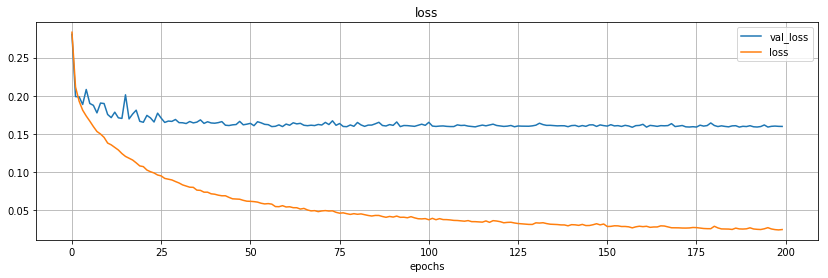

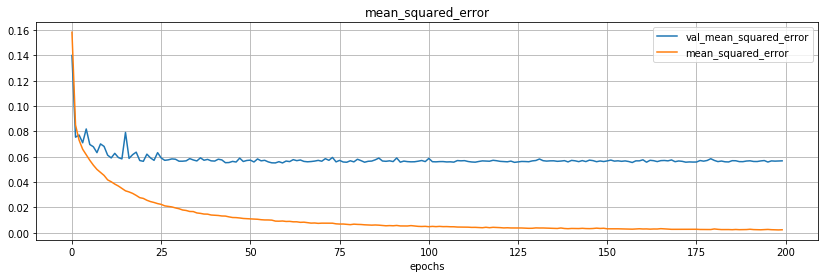

In [47]:
plot_keras_hist(hist)

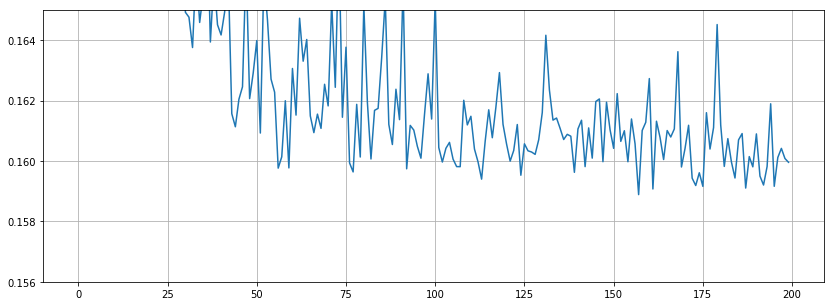

In [48]:
plt.figure(figsize=(14, 5))
plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

In [49]:
df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred');
df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
score = cal_score(df_val['total_price'], df_val['total_price_pred'])
print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

score, mse, mae, mape: 4904.84186, 0.05174, 0.15349, 0.01151


- score, mse, mae, mape: 4551.83065, 0.05603, 0.16341, 0.01224 - 256*7 mse
- score, mse, mae, mape: 4643.83454, 0.05401, 0.15939, 0.01194 - 512*9 mse
- score, mse, mae, mape: 4659.83019, 0.05596, 0.16203, 0.01215 - 256*7 mae
- score, mse, mae, mape: 4956.84128, 0.05138, 0.15199, 0.01140 - 1024*10 mae
- score, mse, mae, mape: 4904.84186, 0.05174, 0.15349, 0.01151 - 512*9 mae embedding

In [50]:
df_val.loc[:, [col_target, col_target+'_pred', col_target+'_scaled', col_target+'_scaled_pred', 'total_price', 'total_price_pred']].check()

,log_per_area_total_price,log_per_area_total_price_pred,log_per_area_total_price_scaled,log_per_area_total_price_scaled_pred,total_price,total_price_pred
0,13.959702,13.938886,0.458847,0.437300,10673093.0,10453208.00
1,15.000397,15.182835,1.536101,1.724948,41609072.0,49936712.00
2,14.075616,14.170592,0.578833,0.677146,19443270.0,21380460.00
3,14.225937,14.429402,0.734434,0.945047,5152761.0,6315444.50
4,14.565749,14.454112,1.086184,0.970625,13297622.0,11892979.00
17995,13.969596,13.667778,0.469088,0.156668,36400320.0,26917036.00
17996,14.226914,13.816492,0.735446,0.310606,7743181.5,5136595.00
17997,14.350793,14.280404,0.863676,0.790815,5152761.0,4802533.00
17998,12.829416,12.788353,-0.711145,-0.753651,4850049.0,4654924.00
17999,13.777486,13.291307,0.270230,-0.233028,4725499.5,2906047.75


shape = (18000, 6)


### Grid search

In [68]:
# grid search
params_fix = {'epochs': 500,
              'n_neurons': (512,)*10,
              'optimizer': Adam,
             }

# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {'learning_rate': [0.001, 0.0008, 0.0005],
                  'batch_size': [64, 128, 256], 
                 }
N_fold = 3
N_iter = 4
score_low_bound = 4700 # if score smaller than this, skip the param set

#### Round 1

In [73]:
# Round 1
rand_params_set = [{'learning_rate': 0.001, 'batch_size': 128}]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [74]:
rand_params_set

[{'learning_rate': 0.001, 'batch_size': 128},
 {'learning_rate': 0.001, 'batch_size': 64},
 {'learning_rate': 0.0008, 'batch_size': 128},
 {'learning_rate': 0.0008, 'batch_size': 256},
 {'learning_rate': 0.0005, 'batch_size': 256}]

In [75]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain].reset_index(drop=True)
    df_val = df.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                            n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                            optimizer=params['optimizer'])

        hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=2,
                         validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 211, 'village': 2781, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 9s - loss: 0.2910 - mean_squared_error: 0.1644 - val_loss: 0.2210 - val_mean_squared_error: 0.0908
Epoch 2/500
 - 8s - loss: 0.2105 - mean_squared_error: 0.0841 - val_loss: 0.2005 - val_mean_squared_error: 0.0777
Epoch 3/500
 - 8s - loss: 0.1942 - mean_squared_error: 0.0740 - val_loss: 0.2357 - val_mean_squared_error: 0.0975
Epoch 4/500
 - 8s - loss: 0.1820 - mean_squared_error: 0.0660 - val_loss: 0.1883 - val_mean_squared_error: 0.0689
Epoch 5/500
 - 9s - loss: 0.1728 - mean_squared_error: 0.0607 - val_loss: 0.1858 - val_

Epoch 69/500
 - 8s - loss: 0.0484 - mean_squared_error: 0.0073 - val_loss: 0.1644 - val_mean_squared_error: 0.0576
Epoch 70/500
 - 9s - loss: 0.0489 - mean_squared_error: 0.0072 - val_loss: 0.1638 - val_mean_squared_error: 0.0574
Epoch 71/500
 - 9s - loss: 0.0477 - mean_squared_error: 0.0070 - val_loss: 0.1658 - val_mean_squared_error: 0.0593
Epoch 72/500
 - 9s - loss: 0.0477 - mean_squared_error: 0.0070 - val_loss: 0.1652 - val_mean_squared_error: 0.0583
Epoch 73/500
 - 11s - loss: 0.0486 - mean_squared_error: 0.0072 - val_loss: 0.1639 - val_mean_squared_error: 0.0575
Epoch 74/500
 - 11s - loss: 0.0479 - mean_squared_error: 0.0070 - val_loss: 0.1613 - val_mean_squared_error: 0.0563
Epoch 75/500
 - 10s - loss: 0.0462 - mean_squared_error: 0.0066 - val_loss: 0.1637 - val_mean_squared_error: 0.0579
Epoch 76/500
 - 9s - loss: 0.0469 - mean_squared_error: 0.0067 - val_loss: 0.1616 - val_mean_squared_error: 0.0568
Epoch 77/500
 - 8s - loss: 0.0464 - mean_squared_error: 0.0066 - val_loss: 0.

Epoch 140/500
 - 9s - loss: 0.0306 - mean_squared_error: 0.0033 - val_loss: 0.1618 - val_mean_squared_error: 0.0570
Epoch 141/500
 - 8s - loss: 0.0302 - mean_squared_error: 0.0032 - val_loss: 0.1626 - val_mean_squared_error: 0.0573
Epoch 142/500
 - 9s - loss: 0.0294 - mean_squared_error: 0.0031 - val_loss: 0.1632 - val_mean_squared_error: 0.0580
Epoch 143/500
 - 9s - loss: 0.0303 - mean_squared_error: 0.0032 - val_loss: 0.1622 - val_mean_squared_error: 0.0571
Epoch 144/500
 - 9s - loss: 0.0312 - mean_squared_error: 0.0033 - val_loss: 0.1623 - val_mean_squared_error: 0.0571
Epoch 145/500
 - 9s - loss: 0.0300 - mean_squared_error: 0.0032 - val_loss: 0.1614 - val_mean_squared_error: 0.0569
Epoch 146/500
 - 9s - loss: 0.0317 - mean_squared_error: 0.0034 - val_loss: 0.1624 - val_mean_squared_error: 0.0574
Epoch 147/500
 - 9s - loss: 0.0322 - mean_squared_error: 0.0035 - val_loss: 0.1625 - val_mean_squared_error: 0.0577
Epoch 148/500
 - 9s - loss: 0.0302 - mean_squared_error: 0.0033 - val_lo

Epoch 211/500
 - 9s - loss: 0.0239 - mean_squared_error: 0.0023 - val_loss: 0.1602 - val_mean_squared_error: 0.0568
Epoch 212/500
 - 10s - loss: 0.0239 - mean_squared_error: 0.0023 - val_loss: 0.1621 - val_mean_squared_error: 0.0572
Epoch 213/500
 - 9s - loss: 0.0250 - mean_squared_error: 0.0023 - val_loss: 0.1616 - val_mean_squared_error: 0.0575
Epoch 214/500
 - 9s - loss: 0.0259 - mean_squared_error: 0.0024 - val_loss: 0.1645 - val_mean_squared_error: 0.0590
Epoch 215/500
 - 9s - loss: 0.0265 - mean_squared_error: 0.0025 - val_loss: 0.1617 - val_mean_squared_error: 0.0574
Epoch 216/500
 - 9s - loss: 0.0246 - mean_squared_error: 0.0023 - val_loss: 0.1619 - val_mean_squared_error: 0.0575
Epoch 217/500
 - 9s - loss: 0.0239 - mean_squared_error: 0.0022 - val_loss: 0.1604 - val_mean_squared_error: 0.0565
Epoch 218/500
 - 9s - loss: 0.0231 - mean_squared_error: 0.0021 - val_loss: 0.1608 - val_mean_squared_error: 0.0568
Epoch 219/500
 - 9s - loss: 0.0225 - mean_squared_error: 0.0020 - val_l

Epoch 282/500
 - 8s - loss: 0.0199 - mean_squared_error: 0.0017 - val_loss: 0.1613 - val_mean_squared_error: 0.0574
Epoch 283/500
 - 8s - loss: 0.0202 - mean_squared_error: 0.0017 - val_loss: 0.1610 - val_mean_squared_error: 0.0572
Epoch 284/500
 - 8s - loss: 0.0204 - mean_squared_error: 0.0017 - val_loss: 0.1615 - val_mean_squared_error: 0.0576
Epoch 285/500
 - 8s - loss: 0.0218 - mean_squared_error: 0.0019 - val_loss: 0.1619 - val_mean_squared_error: 0.0578
Epoch 286/500
 - 8s - loss: 0.0216 - mean_squared_error: 0.0018 - val_loss: 0.1618 - val_mean_squared_error: 0.0575
Epoch 287/500
 - 8s - loss: 0.0222 - mean_squared_error: 0.0019 - val_loss: 0.1611 - val_mean_squared_error: 0.0573
Epoch 288/500
 - 8s - loss: 0.0223 - mean_squared_error: 0.0020 - val_loss: 0.1613 - val_mean_squared_error: 0.0574
Epoch 289/500
 - 8s - loss: 0.0200 - mean_squared_error: 0.0018 - val_loss: 0.1609 - val_mean_squared_error: 0.0571
Epoch 290/500
 - 8s - loss: 0.0197 - mean_squared_error: 0.0017 - val_lo

Epoch 353/500
 - 8s - loss: 0.0175 - mean_squared_error: 0.0014 - val_loss: 0.1604 - val_mean_squared_error: 0.0571
Epoch 354/500
 - 8s - loss: 0.0179 - mean_squared_error: 0.0014 - val_loss: 0.1611 - val_mean_squared_error: 0.0573
Epoch 355/500
 - 8s - loss: 0.0183 - mean_squared_error: 0.0015 - val_loss: 0.1608 - val_mean_squared_error: 0.0568
Epoch 356/500
 - 8s - loss: 0.0184 - mean_squared_error: 0.0015 - val_loss: 0.1601 - val_mean_squared_error: 0.0564
Epoch 357/500
 - 8s - loss: 0.0182 - mean_squared_error: 0.0014 - val_loss: 0.1613 - val_mean_squared_error: 0.0571
Epoch 358/500
 - 8s - loss: 0.0188 - mean_squared_error: 0.0015 - val_loss: 0.1617 - val_mean_squared_error: 0.0575
Epoch 359/500
 - 8s - loss: 0.0194 - mean_squared_error: 0.0015 - val_loss: 0.1623 - val_mean_squared_error: 0.0580
Epoch 360/500
 - 8s - loss: 0.0183 - mean_squared_error: 0.0014 - val_loss: 0.1614 - val_mean_squared_error: 0.0576
Epoch 361/500
 - 8s - loss: 0.0181 - mean_squared_error: 0.0014 - val_lo

Epoch 424/500
 - 8s - loss: 0.0163 - mean_squared_error: 0.0012 - val_loss: 0.1605 - val_mean_squared_error: 0.0571
Epoch 425/500
 - 8s - loss: 0.0159 - mean_squared_error: 0.0012 - val_loss: 0.1617 - val_mean_squared_error: 0.0578
Epoch 426/500
 - 8s - loss: 0.0160 - mean_squared_error: 0.0012 - val_loss: 0.1609 - val_mean_squared_error: 0.0571
Epoch 427/500
 - 8s - loss: 0.0184 - mean_squared_error: 0.0014 - val_loss: 0.1635 - val_mean_squared_error: 0.0588
Epoch 428/500
 - 8s - loss: 0.0187 - mean_squared_error: 0.0014 - val_loss: 0.1609 - val_mean_squared_error: 0.0573
Epoch 429/500
 - 8s - loss: 0.0173 - mean_squared_error: 0.0014 - val_loss: 0.1609 - val_mean_squared_error: 0.0570
Epoch 430/500
 - 8s - loss: 0.0169 - mean_squared_error: 0.0013 - val_loss: 0.1607 - val_mean_squared_error: 0.0569
Epoch 431/500
 - 8s - loss: 0.0160 - mean_squared_error: 0.0012 - val_loss: 0.1601 - val_mean_squared_error: 0.0568
Epoch 432/500
 - 8s - loss: 0.0162 - mean_squared_error: 0.0012 - val_lo

Epoch 495/500
 - 8s - loss: 0.0183 - mean_squared_error: 0.0015 - val_loss: 0.1625 - val_mean_squared_error: 0.0579
Epoch 496/500
 - 8s - loss: 0.0177 - mean_squared_error: 0.0015 - val_loss: 0.1621 - val_mean_squared_error: 0.0580
Epoch 497/500
 - 8s - loss: 0.0166 - mean_squared_error: 0.0013 - val_loss: 0.1635 - val_mean_squared_error: 0.0583
Epoch 498/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0015 - val_loss: 0.1612 - val_mean_squared_error: 0.0569
Epoch 499/500
 - 8s - loss: 0.0212 - mean_squared_error: 0.0018 - val_loss: 0.1616 - val_mean_squared_error: 0.0575
Epoch 500/500
 - 8s - loss: 0.0173 - mean_squared_error: 0.0013 - val_loss: 0.1613 - val_mean_squared_error: 0.0573
params: {'epochs': 500, 'n_neurons': (512, 512, 512, 512, 512, 512, 512, 512, 512, 512), 'optimizer': <class 'keras.optimizers.Adam'>, 'learning_rate': 0.001, 'batch_size': 128}
score, mse, mae, mape: 4812.83838, 0.05277, 0.15476, 0.01160
Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 

Epoch 64/500
 - 14s - loss: 0.0529 - mean_squared_error: 0.0082 - val_loss: 0.1635 - val_mean_squared_error: 0.0575
Epoch 65/500
 - 14s - loss: 0.0533 - mean_squared_error: 0.0083 - val_loss: 0.1647 - val_mean_squared_error: 0.0575
Epoch 66/500
 - 14s - loss: 0.0531 - mean_squared_error: 0.0082 - val_loss: 0.1616 - val_mean_squared_error: 0.0565
Epoch 67/500
 - 14s - loss: 0.0521 - mean_squared_error: 0.0080 - val_loss: 0.1628 - val_mean_squared_error: 0.0571
Epoch 68/500
 - 14s - loss: 0.0511 - mean_squared_error: 0.0078 - val_loss: 0.1613 - val_mean_squared_error: 0.0560
Epoch 69/500
 - 14s - loss: 0.0507 - mean_squared_error: 0.0076 - val_loss: 0.1625 - val_mean_squared_error: 0.0565
Epoch 70/500
 - 14s - loss: 0.0506 - mean_squared_error: 0.0075 - val_loss: 0.1638 - val_mean_squared_error: 0.0572
Epoch 71/500
 - 14s - loss: 0.0509 - mean_squared_error: 0.0076 - val_loss: 0.1628 - val_mean_squared_error: 0.0573
Epoch 72/500
 - 14s - loss: 0.0501 - mean_squared_error: 0.0074 - val_lo

Epoch 135/500
 - 14s - loss: 0.0324 - mean_squared_error: 0.0036 - val_loss: 0.1602 - val_mean_squared_error: 0.0562
Epoch 136/500
 - 14s - loss: 0.0331 - mean_squared_error: 0.0048 - val_loss: 0.1604 - val_mean_squared_error: 0.0563
Epoch 137/500
 - 14s - loss: 0.0334 - mean_squared_error: 0.0037 - val_loss: 0.1616 - val_mean_squared_error: 0.0564
Epoch 138/500
 - 14s - loss: 0.0335 - mean_squared_error: 0.0039 - val_loss: 0.1606 - val_mean_squared_error: 0.0564
Epoch 139/500
 - 14s - loss: 0.0328 - mean_squared_error: 0.0036 - val_loss: 0.1631 - val_mean_squared_error: 0.0580
Epoch 140/500
 - 14s - loss: 0.0317 - mean_squared_error: 0.0035 - val_loss: 0.1613 - val_mean_squared_error: 0.0564
Epoch 141/500
 - 14s - loss: 0.0322 - mean_squared_error: 0.0035 - val_loss: 0.1617 - val_mean_squared_error: 0.0566
Epoch 142/500
 - 14s - loss: 0.0317 - mean_squared_error: 0.0034 - val_loss: 0.1609 - val_mean_squared_error: 0.0563
Epoch 143/500
 - 14s - loss: 0.0328 - mean_squared_error: 0.0037

 - 14s - loss: 0.0256 - mean_squared_error: 0.0022 - val_loss: 0.1598 - val_mean_squared_error: 0.0559
Epoch 206/500
 - 14s - loss: 0.0267 - mean_squared_error: 0.0024 - val_loss: 0.1609 - val_mean_squared_error: 0.0567
Epoch 207/500
 - 14s - loss: 0.0264 - mean_squared_error: 0.0023 - val_loss: 0.1603 - val_mean_squared_error: 0.0565
Epoch 208/500
 - 14s - loss: 0.0252 - mean_squared_error: 0.0021 - val_loss: 0.1602 - val_mean_squared_error: 0.0560
Epoch 209/500
 - 14s - loss: 0.0244 - mean_squared_error: 0.0021 - val_loss: 0.1595 - val_mean_squared_error: 0.0558
Epoch 210/500
 - 14s - loss: 0.0251 - mean_squared_error: 0.0036 - val_loss: 0.1597 - val_mean_squared_error: 0.0562
Epoch 211/500
 - 14s - loss: 0.0258 - mean_squared_error: 0.0023 - val_loss: 0.1604 - val_mean_squared_error: 0.0563
Epoch 212/500
 - 14s - loss: 0.0258 - mean_squared_error: 0.0023 - val_loss: 0.1597 - val_mean_squared_error: 0.0563
Epoch 213/500
 - 14s - loss: 0.0253 - mean_squared_error: 0.0022 - val_loss: 0

Epoch 276/500
 - 14s - loss: 0.0242 - mean_squared_error: 0.0021 - val_loss: 0.1594 - val_mean_squared_error: 0.0560
Epoch 277/500
 - 14s - loss: 0.0231 - mean_squared_error: 0.0020 - val_loss: 0.1598 - val_mean_squared_error: 0.0564
Epoch 278/500
 - 14s - loss: 0.0221 - mean_squared_error: 0.0018 - val_loss: 0.1607 - val_mean_squared_error: 0.0567
Epoch 279/500
 - 14s - loss: 0.0218 - mean_squared_error: 0.0019 - val_loss: 0.1593 - val_mean_squared_error: 0.0561
Epoch 280/500
 - 14s - loss: 0.0233 - mean_squared_error: 0.0020 - val_loss: 0.1612 - val_mean_squared_error: 0.0573
Epoch 281/500
 - 14s - loss: 0.0244 - mean_squared_error: 0.0021 - val_loss: 0.1593 - val_mean_squared_error: 0.0560
Epoch 282/500
 - 14s - loss: 0.0217 - mean_squared_error: 0.0018 - val_loss: 0.1591 - val_mean_squared_error: 0.0561
Epoch 283/500
 - 14s - loss: 0.0212 - mean_squared_error: 0.0018 - val_loss: 0.1591 - val_mean_squared_error: 0.0560
Epoch 284/500
 - 14s - loss: 0.0208 - mean_squared_error: 0.0017

 - 14s - loss: 0.0220 - mean_squared_error: 0.0017 - val_loss: 0.1604 - val_mean_squared_error: 0.0569
Epoch 347/500
 - 14s - loss: 0.0204 - mean_squared_error: 0.0026 - val_loss: 0.1589 - val_mean_squared_error: 0.0556
Epoch 348/500
 - 14s - loss: 0.0201 - mean_squared_error: 0.0015 - val_loss: 0.1598 - val_mean_squared_error: 0.0563
Epoch 349/500
 - 14s - loss: 0.0236 - mean_squared_error: 0.0018 - val_loss: 0.1598 - val_mean_squared_error: 0.0561
Epoch 350/500
 - 14s - loss: 0.0228 - mean_squared_error: 0.0018 - val_loss: 0.1592 - val_mean_squared_error: 0.0561
Epoch 351/500
 - 14s - loss: 0.0216 - mean_squared_error: 0.0016 - val_loss: 0.1596 - val_mean_squared_error: 0.0562
Epoch 352/500
 - 14s - loss: 0.0193 - mean_squared_error: 0.0014 - val_loss: 0.1589 - val_mean_squared_error: 0.0560
Epoch 353/500
 - 14s - loss: 0.0201 - mean_squared_error: 0.0015 - val_loss: 0.1601 - val_mean_squared_error: 0.0565
Epoch 354/500
 - 14s - loss: 0.0200 - mean_squared_error: 0.0014 - val_loss: 0

Epoch 417/500
 - 14s - loss: 0.0227 - mean_squared_error: 0.0041 - val_loss: 0.1615 - val_mean_squared_error: 0.0574
Epoch 418/500
 - 14s - loss: 0.0230 - mean_squared_error: 0.0020 - val_loss: 0.1601 - val_mean_squared_error: 0.0564
Epoch 419/500
 - 14s - loss: 0.0235 - mean_squared_error: 0.0026 - val_loss: 0.1601 - val_mean_squared_error: 0.0570
Epoch 420/500
 - 14s - loss: 0.0207 - mean_squared_error: 0.0018 - val_loss: 0.1601 - val_mean_squared_error: 0.0570
Epoch 421/500
 - 14s - loss: 0.0205 - mean_squared_error: 0.0017 - val_loss: 0.1600 - val_mean_squared_error: 0.0564
Epoch 422/500
 - 14s - loss: 0.0206 - mean_squared_error: 0.0017 - val_loss: 0.1592 - val_mean_squared_error: 0.0560
Epoch 423/500
 - 14s - loss: 0.0201 - mean_squared_error: 0.0016 - val_loss: 0.1603 - val_mean_squared_error: 0.0566
Epoch 424/500
 - 14s - loss: 0.0198 - mean_squared_error: 0.0016 - val_loss: 0.1597 - val_mean_squared_error: 0.0564
Epoch 425/500
 - 14s - loss: 0.0209 - mean_squared_error: 0.0017

 - 14s - loss: 0.0233 - mean_squared_error: 0.0022 - val_loss: 0.1609 - val_mean_squared_error: 0.0565
Epoch 488/500
 - 14s - loss: 0.0239 - mean_squared_error: 0.0022 - val_loss: 0.1612 - val_mean_squared_error: 0.0567
Epoch 489/500
 - 14s - loss: 0.0266 - mean_squared_error: 0.0025 - val_loss: 0.1604 - val_mean_squared_error: 0.0565
Epoch 490/500
 - 14s - loss: 0.0227 - mean_squared_error: 0.0020 - val_loss: 0.1607 - val_mean_squared_error: 0.0567
Epoch 491/500
 - 14s - loss: 0.0226 - mean_squared_error: 0.0021 - val_loss: 0.1621 - val_mean_squared_error: 0.0575
Epoch 492/500
 - 14s - loss: 0.0258 - mean_squared_error: 0.0025 - val_loss: 0.1616 - val_mean_squared_error: 0.0574
Epoch 493/500
 - 14s - loss: 0.0246 - mean_squared_error: 0.0022 - val_loss: 0.1610 - val_mean_squared_error: 0.0569
Epoch 494/500
 - 14s - loss: 0.0244 - mean_squared_error: 0.0022 - val_loss: 0.1605 - val_mean_squared_error: 0.0567
Epoch 495/500
 - 14s - loss: 0.0238 - mean_squared_error: 0.0021 - val_loss: 0

Epoch 56/500
 - 8s - loss: 0.0549 - mean_squared_error: 0.0088 - val_loss: 0.1618 - val_mean_squared_error: 0.0557
Epoch 57/500
 - 8s - loss: 0.0538 - mean_squared_error: 0.0084 - val_loss: 0.1617 - val_mean_squared_error: 0.0556
Epoch 58/500
 - 8s - loss: 0.0528 - mean_squared_error: 0.0082 - val_loss: 0.1641 - val_mean_squared_error: 0.0566
Epoch 59/500
 - 8s - loss: 0.0548 - mean_squared_error: 0.0088 - val_loss: 0.1638 - val_mean_squared_error: 0.0567
Epoch 60/500
 - 9s - loss: 0.0529 - mean_squared_error: 0.0081 - val_loss: 0.1646 - val_mean_squared_error: 0.0572
Epoch 61/500
 - 8s - loss: 0.0513 - mean_squared_error: 0.0079 - val_loss: 0.1627 - val_mean_squared_error: 0.0565
Epoch 62/500
 - 9s - loss: 0.0517 - mean_squared_error: 0.0078 - val_loss: 0.1624 - val_mean_squared_error: 0.0563
Epoch 63/500
 - 9s - loss: 0.0500 - mean_squared_error: 0.0075 - val_loss: 0.1652 - val_mean_squared_error: 0.0578
Epoch 64/500
 - 8s - loss: 0.0506 - mean_squared_error: 0.0075 - val_loss: 0.161

 - 8s - loss: 0.0327 - mean_squared_error: 0.0035 - val_loss: 0.1624 - val_mean_squared_error: 0.0574
Epoch 128/500
 - 8s - loss: 0.0320 - mean_squared_error: 0.0035 - val_loss: 0.1650 - val_mean_squared_error: 0.0590
Epoch 129/500
 - 8s - loss: 0.0335 - mean_squared_error: 0.0038 - val_loss: 0.1644 - val_mean_squared_error: 0.0588
Epoch 130/500
 - 8s - loss: 0.0335 - mean_squared_error: 0.0038 - val_loss: 0.1619 - val_mean_squared_error: 0.0572
Epoch 131/500
 - 8s - loss: 0.0321 - mean_squared_error: 0.0034 - val_loss: 0.1621 - val_mean_squared_error: 0.0569
Epoch 132/500
 - 8s - loss: 0.0301 - mean_squared_error: 0.0031 - val_loss: 0.1629 - val_mean_squared_error: 0.0572
Epoch 133/500
 - 8s - loss: 0.0310 - mean_squared_error: 0.0033 - val_loss: 0.1632 - val_mean_squared_error: 0.0574
Epoch 134/500
 - 9s - loss: 0.0314 - mean_squared_error: 0.0033 - val_loss: 0.1622 - val_mean_squared_error: 0.0570
Epoch 135/500
 - 8s - loss: 0.0288 - mean_squared_error: 0.0029 - val_loss: 0.1642 - v

Epoch 198/500
 - 8s - loss: 0.0243 - mean_squared_error: 0.0020 - val_loss: 0.1626 - val_mean_squared_error: 0.0579
Epoch 199/500
 - 8s - loss: 0.0243 - mean_squared_error: 0.0021 - val_loss: 0.1619 - val_mean_squared_error: 0.0574
Epoch 200/500
 - 8s - loss: 0.0238 - mean_squared_error: 0.0021 - val_loss: 0.1609 - val_mean_squared_error: 0.0570
Epoch 201/500
 - 8s - loss: 0.0227 - mean_squared_error: 0.0019 - val_loss: 0.1617 - val_mean_squared_error: 0.0573
Epoch 202/500
 - 8s - loss: 0.0230 - mean_squared_error: 0.0019 - val_loss: 0.1627 - val_mean_squared_error: 0.0577
Epoch 203/500
 - 8s - loss: 0.0238 - mean_squared_error: 0.0019 - val_loss: 0.1613 - val_mean_squared_error: 0.0570
Epoch 204/500
 - 8s - loss: 0.0235 - mean_squared_error: 0.0020 - val_loss: 0.1616 - val_mean_squared_error: 0.0570
Epoch 205/500
 - 9s - loss: 0.0247 - mean_squared_error: 0.0024 - val_loss: 0.1620 - val_mean_squared_error: 0.0571
Epoch 206/500
 - 9s - loss: 0.0252 - mean_squared_error: 0.0023 - val_lo

Epoch 269/500
 - 8s - loss: 0.0202 - mean_squared_error: 0.0015 - val_loss: 0.1620 - val_mean_squared_error: 0.0575
Epoch 270/500
 - 8s - loss: 0.0207 - mean_squared_error: 0.0015 - val_loss: 0.1638 - val_mean_squared_error: 0.0587
Epoch 271/500
 - 8s - loss: 0.0199 - mean_squared_error: 0.0015 - val_loss: 0.1614 - val_mean_squared_error: 0.0575
Epoch 272/500
 - 8s - loss: 0.0198 - mean_squared_error: 0.0014 - val_loss: 0.1617 - val_mean_squared_error: 0.0573
Epoch 273/500
 - 8s - loss: 0.0196 - mean_squared_error: 0.0014 - val_loss: 0.1614 - val_mean_squared_error: 0.0572
Epoch 274/500
 - 8s - loss: 0.0192 - mean_squared_error: 0.0014 - val_loss: 0.1655 - val_mean_squared_error: 0.0590
Epoch 275/500
 - 8s - loss: 0.0236 - mean_squared_error: 0.0019 - val_loss: 0.1618 - val_mean_squared_error: 0.0574
Epoch 276/500
 - 9s - loss: 0.0220 - mean_squared_error: 0.0017 - val_loss: 0.1620 - val_mean_squared_error: 0.0578
Epoch 277/500
 - 9s - loss: 0.0201 - mean_squared_error: 0.0015 - val_lo

Epoch 340/500
 - 8s - loss: 0.0197 - mean_squared_error: 0.0015 - val_loss: 0.1625 - val_mean_squared_error: 0.0580
Epoch 341/500
 - 8s - loss: 0.0204 - mean_squared_error: 0.0016 - val_loss: 0.1609 - val_mean_squared_error: 0.0570
Epoch 342/500
 - 8s - loss: 0.0181 - mean_squared_error: 0.0013 - val_loss: 0.1608 - val_mean_squared_error: 0.0569
Epoch 343/500
 - 9s - loss: 0.0177 - mean_squared_error: 0.0014 - val_loss: 0.1616 - val_mean_squared_error: 0.0578
Epoch 344/500
 - 8s - loss: 0.0186 - mean_squared_error: 0.0014 - val_loss: 0.1624 - val_mean_squared_error: 0.0579
Epoch 345/500
 - 8s - loss: 0.0198 - mean_squared_error: 0.0015 - val_loss: 0.1626 - val_mean_squared_error: 0.0581
Epoch 346/500
 - 9s - loss: 0.0181 - mean_squared_error: 0.0014 - val_loss: 0.1606 - val_mean_squared_error: 0.0570
Epoch 347/500
 - 9s - loss: 0.0186 - mean_squared_error: 0.0014 - val_loss: 0.1618 - val_mean_squared_error: 0.0576
Epoch 348/500
 - 9s - loss: 0.0166 - mean_squared_error: 0.0012 - val_lo

Epoch 411/500
 - 8s - loss: 0.0167 - mean_squared_error: 0.0011 - val_loss: 0.1608 - val_mean_squared_error: 0.0572
Epoch 412/500
 - 8s - loss: 0.0157 - mean_squared_error: 0.0011 - val_loss: 0.1617 - val_mean_squared_error: 0.0578
Epoch 413/500
 - 8s - loss: 0.0167 - mean_squared_error: 0.0012 - val_loss: 0.1616 - val_mean_squared_error: 0.0577
Epoch 414/500
 - 8s - loss: 0.0171 - mean_squared_error: 0.0012 - val_loss: 0.1618 - val_mean_squared_error: 0.0579
Epoch 415/500
 - 8s - loss: 0.0173 - mean_squared_error: 0.0012 - val_loss: 0.1617 - val_mean_squared_error: 0.0579
Epoch 416/500
 - 8s - loss: 0.0178 - mean_squared_error: 0.0013 - val_loss: 0.1622 - val_mean_squared_error: 0.0580
Epoch 417/500
 - 8s - loss: 0.0168 - mean_squared_error: 0.0012 - val_loss: 0.1606 - val_mean_squared_error: 0.0573
Epoch 418/500
 - 9s - loss: 0.0160 - mean_squared_error: 0.0011 - val_loss: 0.1616 - val_mean_squared_error: 0.0576
Epoch 419/500
 - 9s - loss: 0.0152 - mean_squared_error: 0.0012 - val_lo

Epoch 482/500
 - 8s - loss: 0.0156 - mean_squared_error: 0.0013 - val_loss: 0.1608 - val_mean_squared_error: 0.0573
Epoch 483/500
 - 8s - loss: 0.0159 - mean_squared_error: 0.0013 - val_loss: 0.1622 - val_mean_squared_error: 0.0581
Epoch 484/500
 - 8s - loss: 0.0158 - mean_squared_error: 0.0013 - val_loss: 0.1628 - val_mean_squared_error: 0.0586
Epoch 485/500
 - 8s - loss: 0.0149 - mean_squared_error: 0.0011 - val_loss: 0.1617 - val_mean_squared_error: 0.0579
Epoch 486/500
 - 8s - loss: 0.0148 - mean_squared_error: 0.0011 - val_loss: 0.1615 - val_mean_squared_error: 0.0580
Epoch 487/500
 - 8s - loss: 0.0148 - mean_squared_error: 0.0010 - val_loss: 0.1606 - val_mean_squared_error: 0.0575
Epoch 488/500
 - 8s - loss: 0.0158 - mean_squared_error: 0.0011 - val_loss: 0.1625 - val_mean_squared_error: 0.0582
Epoch 489/500
 - 9s - loss: 0.0154 - mean_squared_error: 0.0011 - val_loss: 0.1616 - val_mean_squared_error: 0.0580
Epoch 490/500
 - 8s - loss: 0.0154 - mean_squared_error: 0.0011 - val_lo

Epoch 51/500
 - 6s - loss: 0.0581 - mean_squared_error: 0.0096 - val_loss: 0.1657 - val_mean_squared_error: 0.0583
Epoch 52/500
 - 6s - loss: 0.0588 - mean_squared_error: 0.0099 - val_loss: 0.1676 - val_mean_squared_error: 0.0595
Epoch 53/500
 - 6s - loss: 0.0569 - mean_squared_error: 0.0093 - val_loss: 0.1669 - val_mean_squared_error: 0.0588
Epoch 54/500
 - 6s - loss: 0.0591 - mean_squared_error: 0.0098 - val_loss: 0.1717 - val_mean_squared_error: 0.0609
Epoch 55/500
 - 6s - loss: 0.0561 - mean_squared_error: 0.0090 - val_loss: 0.1658 - val_mean_squared_error: 0.0587
Epoch 56/500
 - 6s - loss: 0.0531 - mean_squared_error: 0.0084 - val_loss: 0.1640 - val_mean_squared_error: 0.0576
Epoch 57/500
 - 6s - loss: 0.0565 - mean_squared_error: 0.0092 - val_loss: 0.1678 - val_mean_squared_error: 0.0596
Epoch 58/500
 - 6s - loss: 0.0566 - mean_squared_error: 0.0091 - val_loss: 0.1636 - val_mean_squared_error: 0.0572
Epoch 59/500
 - 6s - loss: 0.0524 - mean_squared_error: 0.0082 - val_loss: 0.165

 - 6s - loss: 0.0326 - mean_squared_error: 0.0039 - val_loss: 0.1636 - val_mean_squared_error: 0.0575
Epoch 123/500
 - 6s - loss: 0.0341 - mean_squared_error: 0.0041 - val_loss: 0.1646 - val_mean_squared_error: 0.0588
Epoch 124/500
 - 6s - loss: 0.0328 - mean_squared_error: 0.0039 - val_loss: 0.1657 - val_mean_squared_error: 0.0592
Epoch 125/500
 - 6s - loss: 0.0325 - mean_squared_error: 0.0039 - val_loss: 0.1649 - val_mean_squared_error: 0.0586
Epoch 126/500
 - 6s - loss: 0.0314 - mean_squared_error: 0.0037 - val_loss: 0.1641 - val_mean_squared_error: 0.0582
Epoch 127/500
 - 6s - loss: 0.0329 - mean_squared_error: 0.0040 - val_loss: 0.1646 - val_mean_squared_error: 0.0585
Epoch 128/500
 - 6s - loss: 0.0341 - mean_squared_error: 0.0041 - val_loss: 0.1662 - val_mean_squared_error: 0.0590
Epoch 129/500
 - 6s - loss: 0.0331 - mean_squared_error: 0.0039 - val_loss: 0.1656 - val_mean_squared_error: 0.0591
Epoch 130/500
 - 6s - loss: 0.0343 - mean_squared_error: 0.0041 - val_loss: 0.1635 - v

Epoch 193/500
 - 6s - loss: 0.0362 - mean_squared_error: 0.0047 - val_loss: 0.1687 - val_mean_squared_error: 0.0609
Epoch 194/500
 - 6s - loss: 0.0334 - mean_squared_error: 0.0039 - val_loss: 0.1676 - val_mean_squared_error: 0.0608
Epoch 195/500
 - 6s - loss: 0.0310 - mean_squared_error: 0.0034 - val_loss: 0.1652 - val_mean_squared_error: 0.0591
Epoch 196/500
 - 6s - loss: 0.0281 - mean_squared_error: 0.0031 - val_loss: 0.1658 - val_mean_squared_error: 0.0598
Epoch 197/500
 - 6s - loss: 0.0284 - mean_squared_error: 0.0031 - val_loss: 0.1664 - val_mean_squared_error: 0.0602
Epoch 198/500
 - 6s - loss: 0.0292 - mean_squared_error: 0.0033 - val_loss: 0.1651 - val_mean_squared_error: 0.0592
Epoch 199/500
 - 6s - loss: 0.0306 - mean_squared_error: 0.0037 - val_loss: 0.1660 - val_mean_squared_error: 0.0599
Epoch 200/500
 - 6s - loss: 0.0318 - mean_squared_error: 0.0037 - val_loss: 0.1646 - val_mean_squared_error: 0.0593
Epoch 201/500
 - 6s - loss: 0.0282 - mean_squared_error: 0.0031 - val_lo

Epoch 264/500
 - 6s - loss: 0.0227 - mean_squared_error: 0.0022 - val_loss: 0.1656 - val_mean_squared_error: 0.0603
Epoch 265/500
 - 6s - loss: 0.0230 - mean_squared_error: 0.0022 - val_loss: 0.1660 - val_mean_squared_error: 0.0601
Epoch 266/500
 - 6s - loss: 0.0238 - mean_squared_error: 0.0023 - val_loss: 0.1675 - val_mean_squared_error: 0.0612
Epoch 267/500
 - 6s - loss: 0.0234 - mean_squared_error: 0.0023 - val_loss: 0.1648 - val_mean_squared_error: 0.0596
Epoch 268/500
 - 6s - loss: 0.0253 - mean_squared_error: 0.0027 - val_loss: 0.1660 - val_mean_squared_error: 0.0600
Epoch 269/500
 - 6s - loss: 0.0253 - mean_squared_error: 0.0026 - val_loss: 0.1662 - val_mean_squared_error: 0.0607
Epoch 270/500
 - 6s - loss: 0.0244 - mean_squared_error: 0.0024 - val_loss: 0.1657 - val_mean_squared_error: 0.0604
Epoch 271/500
 - 6s - loss: 0.0232 - mean_squared_error: 0.0022 - val_loss: 0.1690 - val_mean_squared_error: 0.0618
Epoch 272/500
 - 6s - loss: 0.0274 - mean_squared_error: 0.0028 - val_lo

Epoch 335/500
 - 6s - loss: 0.0214 - mean_squared_error: 0.0021 - val_loss: 0.1653 - val_mean_squared_error: 0.0601
Epoch 336/500
 - 6s - loss: 0.0189 - mean_squared_error: 0.0017 - val_loss: 0.1663 - val_mean_squared_error: 0.0607
Epoch 337/500
 - 6s - loss: 0.0188 - mean_squared_error: 0.0017 - val_loss: 0.1656 - val_mean_squared_error: 0.0605
Epoch 338/500
 - 6s - loss: 0.0202 - mean_squared_error: 0.0020 - val_loss: 0.1654 - val_mean_squared_error: 0.0606
Epoch 339/500
 - 6s - loss: 0.0184 - mean_squared_error: 0.0016 - val_loss: 0.1655 - val_mean_squared_error: 0.0603
Epoch 340/500
 - 6s - loss: 0.0187 - mean_squared_error: 0.0016 - val_loss: 0.1658 - val_mean_squared_error: 0.0602
Epoch 341/500
 - 6s - loss: 0.0193 - mean_squared_error: 0.0017 - val_loss: 0.1655 - val_mean_squared_error: 0.0606
Epoch 342/500
 - 6s - loss: 0.0184 - mean_squared_error: 0.0016 - val_loss: 0.1647 - val_mean_squared_error: 0.0601
Epoch 343/500
 - 6s - loss: 0.0186 - mean_squared_error: 0.0016 - val_lo

Epoch 406/500
 - 6s - loss: 0.0205 - mean_squared_error: 0.0021 - val_loss: 0.1719 - val_mean_squared_error: 0.0637
Epoch 407/500
 - 6s - loss: 0.0301 - mean_squared_error: 0.0037 - val_loss: 0.1686 - val_mean_squared_error: 0.0624
Epoch 408/500
 - 6s - loss: 0.0306 - mean_squared_error: 0.0035 - val_loss: 0.1709 - val_mean_squared_error: 0.0642
Epoch 409/500
 - 6s - loss: 0.0289 - mean_squared_error: 0.0032 - val_loss: 0.1688 - val_mean_squared_error: 0.0622
Epoch 410/500
 - 6s - loss: 0.0283 - mean_squared_error: 0.0035 - val_loss: 0.1688 - val_mean_squared_error: 0.0623
Epoch 411/500
 - 6s - loss: 0.0244 - mean_squared_error: 0.0025 - val_loss: 0.1680 - val_mean_squared_error: 0.0624
Epoch 412/500
 - 6s - loss: 0.0237 - mean_squared_error: 0.0026 - val_loss: 0.1676 - val_mean_squared_error: 0.0619
Epoch 413/500
 - 6s - loss: 0.0206 - mean_squared_error: 0.0019 - val_loss: 0.1670 - val_mean_squared_error: 0.0615
Epoch 414/500
 - 6s - loss: 0.0206 - mean_squared_error: 0.0019 - val_lo

Epoch 477/500
 - 6s - loss: 0.0222 - mean_squared_error: 0.0024 - val_loss: 0.1682 - val_mean_squared_error: 0.0620
Epoch 478/500
 - 6s - loss: 0.0208 - mean_squared_error: 0.0020 - val_loss: 0.1678 - val_mean_squared_error: 0.0617
Epoch 479/500
 - 6s - loss: 0.0218 - mean_squared_error: 0.0022 - val_loss: 0.1686 - val_mean_squared_error: 0.0623
Epoch 480/500
 - 6s - loss: 0.0209 - mean_squared_error: 0.0020 - val_loss: 0.1675 - val_mean_squared_error: 0.0617
Epoch 481/500
 - 6s - loss: 0.0196 - mean_squared_error: 0.0019 - val_loss: 0.1685 - val_mean_squared_error: 0.0625
Epoch 482/500
 - 6s - loss: 0.0196 - mean_squared_error: 0.0020 - val_loss: 0.1673 - val_mean_squared_error: 0.0617
Epoch 483/500
 - 6s - loss: 0.0194 - mean_squared_error: 0.0019 - val_loss: 0.1668 - val_mean_squared_error: 0.0613
Epoch 484/500
 - 6s - loss: 0.0179 - mean_squared_error: 0.0017 - val_loss: 0.1669 - val_mean_squared_error: 0.0615
Epoch 485/500
 - 6s - loss: 0.0173 - mean_squared_error: 0.0018 - val_lo

Epoch 46/500
 - 6s - loss: 0.0612 - mean_squared_error: 0.0098 - val_loss: 0.1638 - val_mean_squared_error: 0.0561
Epoch 47/500
 - 6s - loss: 0.0576 - mean_squared_error: 0.0090 - val_loss: 0.1668 - val_mean_squared_error: 0.0577
Epoch 48/500
 - 6s - loss: 0.0578 - mean_squared_error: 0.0089 - val_loss: 0.1705 - val_mean_squared_error: 0.0591
Epoch 49/500
 - 6s - loss: 0.0584 - mean_squared_error: 0.0090 - val_loss: 0.1661 - val_mean_squared_error: 0.0574
Epoch 50/500
 - 6s - loss: 0.0556 - mean_squared_error: 0.0083 - val_loss: 0.1651 - val_mean_squared_error: 0.0572
Epoch 51/500
 - 6s - loss: 0.0547 - mean_squared_error: 0.0082 - val_loss: 0.1648 - val_mean_squared_error: 0.0574
Epoch 52/500
 - 6s - loss: 0.0541 - mean_squared_error: 0.0080 - val_loss: 0.1659 - val_mean_squared_error: 0.0581
Epoch 53/500
 - 6s - loss: 0.0527 - mean_squared_error: 0.0077 - val_loss: 0.1631 - val_mean_squared_error: 0.0563
Epoch 54/500
 - 6s - loss: 0.0541 - mean_squared_error: 0.0079 - val_loss: 0.170

 - 6s - loss: 0.0340 - mean_squared_error: 0.0036 - val_loss: 0.1650 - val_mean_squared_error: 0.0582
Epoch 118/500
 - 6s - loss: 0.0334 - mean_squared_error: 0.0035 - val_loss: 0.1644 - val_mean_squared_error: 0.0581
Epoch 119/500
 - 6s - loss: 0.0331 - mean_squared_error: 0.0034 - val_loss: 0.1649 - val_mean_squared_error: 0.0585
Epoch 120/500
 - 6s - loss: 0.0367 - mean_squared_error: 0.0041 - val_loss: 0.1689 - val_mean_squared_error: 0.0607
Epoch 121/500
 - 6s - loss: 0.0360 - mean_squared_error: 0.0040 - val_loss: 0.1640 - val_mean_squared_error: 0.0574
Epoch 122/500
 - 6s - loss: 0.0350 - mean_squared_error: 0.0038 - val_loss: 0.1670 - val_mean_squared_error: 0.0598
Epoch 123/500
 - 6s - loss: 0.0339 - mean_squared_error: 0.0036 - val_loss: 0.1652 - val_mean_squared_error: 0.0581
Epoch 124/500
 - 6s - loss: 0.0332 - mean_squared_error: 0.0034 - val_loss: 0.1656 - val_mean_squared_error: 0.0591
Epoch 125/500
 - 6s - loss: 0.0326 - mean_squared_error: 0.0033 - val_loss: 0.1650 - v

Epoch 188/500
 - 6s - loss: 0.0257 - mean_squared_error: 0.0023 - val_loss: 0.1655 - val_mean_squared_error: 0.0592
Epoch 189/500
 - 6s - loss: 0.0264 - mean_squared_error: 0.0024 - val_loss: 0.1653 - val_mean_squared_error: 0.0591
Epoch 190/500
 - 6s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1660 - val_mean_squared_error: 0.0595
Epoch 191/500
 - 6s - loss: 0.0273 - mean_squared_error: 0.0025 - val_loss: 0.1643 - val_mean_squared_error: 0.0589
Epoch 192/500
 - 6s - loss: 0.0283 - mean_squared_error: 0.0027 - val_loss: 0.1652 - val_mean_squared_error: 0.0588
Epoch 193/500
 - 6s - loss: 0.0262 - mean_squared_error: 0.0023 - val_loss: 0.1657 - val_mean_squared_error: 0.0593
Epoch 194/500
 - 6s - loss: 0.0248 - mean_squared_error: 0.0021 - val_loss: 0.1672 - val_mean_squared_error: 0.0604
Epoch 195/500
 - 6s - loss: 0.0236 - mean_squared_error: 0.0019 - val_loss: 0.1646 - val_mean_squared_error: 0.0589
Epoch 196/500
 - 6s - loss: 0.0233 - mean_squared_error: 0.0019 - val_lo

Epoch 259/500
 - 6s - loss: 0.0188 - mean_squared_error: 0.0014 - val_loss: 0.1644 - val_mean_squared_error: 0.0589
Epoch 260/500
 - 6s - loss: 0.0217 - mean_squared_error: 0.0020 - val_loss: 0.1663 - val_mean_squared_error: 0.0605
Epoch 261/500
 - 6s - loss: 0.0196 - mean_squared_error: 0.0017 - val_loss: 0.1661 - val_mean_squared_error: 0.0593
Epoch 262/500
 - 6s - loss: 0.0202 - mean_squared_error: 0.0016 - val_loss: 0.1662 - val_mean_squared_error: 0.0601
Epoch 263/500
 - 6s - loss: 0.0197 - mean_squared_error: 0.0016 - val_loss: 0.1651 - val_mean_squared_error: 0.0592
Epoch 264/500
 - 6s - loss: 0.0208 - mean_squared_error: 0.0018 - val_loss: 0.1667 - val_mean_squared_error: 0.0598
Epoch 265/500
 - 6s - loss: 0.0222 - mean_squared_error: 0.0020 - val_loss: 0.1660 - val_mean_squared_error: 0.0597
Epoch 266/500
 - 6s - loss: 0.0215 - mean_squared_error: 0.0018 - val_loss: 0.1667 - val_mean_squared_error: 0.0600
Epoch 267/500
 - 6s - loss: 0.0208 - mean_squared_error: 0.0017 - val_lo

Epoch 330/500
 - 6s - loss: 0.0172 - mean_squared_error: 0.0014 - val_loss: 0.1667 - val_mean_squared_error: 0.0603
Epoch 331/500
 - 6s - loss: 0.0192 - mean_squared_error: 0.0016 - val_loss: 0.1657 - val_mean_squared_error: 0.0598
Epoch 332/500
 - 6s - loss: 0.0173 - mean_squared_error: 0.0014 - val_loss: 0.1665 - val_mean_squared_error: 0.0602
Epoch 333/500
 - 6s - loss: 0.0162 - mean_squared_error: 0.0013 - val_loss: 0.1667 - val_mean_squared_error: 0.0605
Epoch 334/500
 - 6s - loss: 0.0163 - mean_squared_error: 0.0013 - val_loss: 0.1666 - val_mean_squared_error: 0.0600
Epoch 335/500
 - 6s - loss: 0.0176 - mean_squared_error: 0.0014 - val_loss: 0.1675 - val_mean_squared_error: 0.0606
Epoch 336/500
 - 6s - loss: 0.0191 - mean_squared_error: 0.0016 - val_loss: 0.1696 - val_mean_squared_error: 0.0615
Epoch 337/500
 - 6s - loss: 0.0234 - mean_squared_error: 0.0023 - val_loss: 0.1687 - val_mean_squared_error: 0.0612
Epoch 338/500
 - 6s - loss: 0.0246 - mean_squared_error: 0.0024 - val_lo

Epoch 401/500
 - 6s - loss: 0.0164 - mean_squared_error: 0.0014 - val_loss: 0.1669 - val_mean_squared_error: 0.0604
Epoch 402/500
 - 6s - loss: 0.0232 - mean_squared_error: 0.0024 - val_loss: 0.1686 - val_mean_squared_error: 0.0613
Epoch 403/500
 - 6s - loss: 0.0207 - mean_squared_error: 0.0019 - val_loss: 0.1689 - val_mean_squared_error: 0.0611
Epoch 404/500
 - 6s - loss: 0.0213 - mean_squared_error: 0.0020 - val_loss: 0.1690 - val_mean_squared_error: 0.0620
Epoch 405/500
 - 6s - loss: 0.0230 - mean_squared_error: 0.0024 - val_loss: 0.1681 - val_mean_squared_error: 0.0610
Epoch 406/500
 - 6s - loss: 0.0266 - mean_squared_error: 0.0029 - val_loss: 0.1693 - val_mean_squared_error: 0.0616
Epoch 407/500
 - 6s - loss: 0.0255 - mean_squared_error: 0.0027 - val_loss: 0.1718 - val_mean_squared_error: 0.0636
Epoch 408/500
 - 6s - loss: 0.0233 - mean_squared_error: 0.0023 - val_loss: 0.1699 - val_mean_squared_error: 0.0628
Epoch 409/500
 - 6s - loss: 0.0229 - mean_squared_error: 0.0022 - val_lo

Epoch 472/500
 - 6s - loss: 0.0141 - mean_squared_error: 0.0010 - val_loss: 0.1674 - val_mean_squared_error: 0.0610
Epoch 473/500
 - 6s - loss: 0.0148 - mean_squared_error: 0.0011 - val_loss: 0.1667 - val_mean_squared_error: 0.0603
Epoch 474/500
 - 6s - loss: 0.0168 - mean_squared_error: 0.0013 - val_loss: 0.1676 - val_mean_squared_error: 0.0607
Epoch 475/500
 - 6s - loss: 0.0177 - mean_squared_error: 0.0015 - val_loss: 0.1676 - val_mean_squared_error: 0.0614
Epoch 476/500
 - 6s - loss: 0.0201 - mean_squared_error: 0.0019 - val_loss: 0.1687 - val_mean_squared_error: 0.0617
Epoch 477/500
 - 6s - loss: 0.0244 - mean_squared_error: 0.0026 - val_loss: 0.1711 - val_mean_squared_error: 0.0633
Epoch 478/500
 - 6s - loss: 0.0251 - mean_squared_error: 0.0027 - val_loss: 0.1691 - val_mean_squared_error: 0.0618
Epoch 479/500
 - 6s - loss: 0.0262 - mean_squared_error: 0.0029 - val_loss: 0.1688 - val_mean_squared_error: 0.0619
Epoch 480/500
 - 6s - loss: 0.0193 - mean_squared_error: 0.0016 - val_lo

Epoch 37/500
 - 9s - loss: 0.0748 - mean_squared_error: 0.0145 - val_loss: 0.1683 - val_mean_squared_error: 0.0609
Epoch 38/500
 - 9s - loss: 0.0736 - mean_squared_error: 0.0142 - val_loss: 0.1652 - val_mean_squared_error: 0.0596
Epoch 39/500
 - 9s - loss: 0.0724 - mean_squared_error: 0.0138 - val_loss: 0.1659 - val_mean_squared_error: 0.0596
Epoch 40/500
 - 8s - loss: 0.0717 - mean_squared_error: 0.0136 - val_loss: 0.1672 - val_mean_squared_error: 0.0610
Epoch 41/500
 - 9s - loss: 0.0713 - mean_squared_error: 0.0134 - val_loss: 0.1645 - val_mean_squared_error: 0.0598
Epoch 42/500
 - 9s - loss: 0.0683 - mean_squared_error: 0.0126 - val_loss: 0.1656 - val_mean_squared_error: 0.0599
Epoch 43/500
 - 9s - loss: 0.0679 - mean_squared_error: 0.0123 - val_loss: 0.1652 - val_mean_squared_error: 0.0593
Epoch 44/500
 - 9s - loss: 0.0671 - mean_squared_error: 0.0121 - val_loss: 0.1665 - val_mean_squared_error: 0.0603
Epoch 45/500
 - 9s - loss: 0.0643 - mean_squared_error: 0.0114 - val_loss: 0.164

Epoch 109/500
 - 9s - loss: 0.0382 - mean_squared_error: 0.0047 - val_loss: 0.1645 - val_mean_squared_error: 0.0596
Epoch 110/500
 - 9s - loss: 0.0353 - mean_squared_error: 0.0042 - val_loss: 0.1623 - val_mean_squared_error: 0.0587
Epoch 111/500
 - 9s - loss: 0.0366 - mean_squared_error: 0.0044 - val_loss: 0.1644 - val_mean_squared_error: 0.0606
Epoch 112/500
 - 9s - loss: 0.0351 - mean_squared_error: 0.0042 - val_loss: 0.1616 - val_mean_squared_error: 0.0587
Epoch 113/500
 - 8s - loss: 0.0357 - mean_squared_error: 0.0044 - val_loss: 0.1615 - val_mean_squared_error: 0.0586
Epoch 114/500
 - 9s - loss: 0.0382 - mean_squared_error: 0.0047 - val_loss: 0.1636 - val_mean_squared_error: 0.0599
Epoch 115/500
 - 9s - loss: 0.0364 - mean_squared_error: 0.0044 - val_loss: 0.1617 - val_mean_squared_error: 0.0591
Epoch 116/500
 - 9s - loss: 0.0353 - mean_squared_error: 0.0042 - val_loss: 0.1617 - val_mean_squared_error: 0.0587
Epoch 117/500
 - 8s - loss: 0.0343 - mean_squared_error: 0.0040 - val_lo

Epoch 180/500
 - 9s - loss: 0.0258 - mean_squared_error: 0.0026 - val_loss: 0.1617 - val_mean_squared_error: 0.0592
Epoch 181/500
 - 8s - loss: 0.0260 - mean_squared_error: 0.0026 - val_loss: 0.1600 - val_mean_squared_error: 0.0581
Epoch 182/500
 - 9s - loss: 0.0248 - mean_squared_error: 0.0025 - val_loss: 0.1610 - val_mean_squared_error: 0.0594
Epoch 183/500
 - 9s - loss: 0.0244 - mean_squared_error: 0.0028 - val_loss: 0.1613 - val_mean_squared_error: 0.0586
Epoch 184/500
 - 9s - loss: 0.0247 - mean_squared_error: 0.0026 - val_loss: 0.1604 - val_mean_squared_error: 0.0581
Epoch 185/500
 - 9s - loss: 0.0259 - mean_squared_error: 0.0026 - val_loss: 0.1611 - val_mean_squared_error: 0.0583
Epoch 186/500
 - 9s - loss: 0.0248 - mean_squared_error: 0.0024 - val_loss: 0.1610 - val_mean_squared_error: 0.0590
Epoch 187/500
 - 9s - loss: 0.0251 - mean_squared_error: 0.0025 - val_loss: 0.1616 - val_mean_squared_error: 0.0591
Epoch 188/500
 - 9s - loss: 0.0253 - mean_squared_error: 0.0024 - val_lo

Epoch 251/500
 - 9s - loss: 0.0210 - mean_squared_error: 0.0020 - val_loss: 0.1608 - val_mean_squared_error: 0.0586
Epoch 252/500
 - 9s - loss: 0.0207 - mean_squared_error: 0.0019 - val_loss: 0.1617 - val_mean_squared_error: 0.0595
Epoch 253/500
 - 8s - loss: 0.0209 - mean_squared_error: 0.0019 - val_loss: 0.1599 - val_mean_squared_error: 0.0585
Epoch 254/500
 - 8s - loss: 0.0216 - mean_squared_error: 0.0020 - val_loss: 0.1622 - val_mean_squared_error: 0.0594
Epoch 255/500
 - 9s - loss: 0.0219 - mean_squared_error: 0.0020 - val_loss: 0.1609 - val_mean_squared_error: 0.0588
Epoch 256/500
 - 9s - loss: 0.0222 - mean_squared_error: 0.0020 - val_loss: 0.1605 - val_mean_squared_error: 0.0589
Epoch 257/500
 - 9s - loss: 0.0212 - mean_squared_error: 0.0032 - val_loss: 0.1615 - val_mean_squared_error: 0.0591
Epoch 258/500
 - 9s - loss: 0.0205 - mean_squared_error: 0.0019 - val_loss: 0.1605 - val_mean_squared_error: 0.0586
Epoch 259/500
 - 9s - loss: 0.0206 - mean_squared_error: 0.0019 - val_lo

Epoch 322/500
 - 9s - loss: 0.0185 - mean_squared_error: 0.0017 - val_loss: 0.1622 - val_mean_squared_error: 0.0602
Epoch 323/500
 - 9s - loss: 0.0200 - mean_squared_error: 0.0018 - val_loss: 0.1609 - val_mean_squared_error: 0.0589
Epoch 324/500
 - 9s - loss: 0.0186 - mean_squared_error: 0.0016 - val_loss: 0.1605 - val_mean_squared_error: 0.0591
Epoch 325/500
 - 9s - loss: 0.0199 - mean_squared_error: 0.0017 - val_loss: 0.1611 - val_mean_squared_error: 0.0594
Epoch 326/500
 - 9s - loss: 0.0190 - mean_squared_error: 0.0016 - val_loss: 0.1609 - val_mean_squared_error: 0.0589
Epoch 327/500
 - 9s - loss: 0.0189 - mean_squared_error: 0.0017 - val_loss: 0.1614 - val_mean_squared_error: 0.0595
Epoch 328/500
 - 9s - loss: 0.0191 - mean_squared_error: 0.0017 - val_loss: 0.1615 - val_mean_squared_error: 0.0592
Epoch 329/500
 - 9s - loss: 0.0187 - mean_squared_error: 0.0017 - val_loss: 0.1606 - val_mean_squared_error: 0.0587
Epoch 330/500
 - 9s - loss: 0.0181 - mean_squared_error: 0.0021 - val_lo

Epoch 393/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0015 - val_loss: 0.1607 - val_mean_squared_error: 0.0588
Epoch 394/500
 - 9s - loss: 0.0180 - mean_squared_error: 0.0017 - val_loss: 0.1611 - val_mean_squared_error: 0.0590
Epoch 395/500
 - 9s - loss: 0.0170 - mean_squared_error: 0.0015 - val_loss: 0.1613 - val_mean_squared_error: 0.0593
Epoch 396/500
 - 9s - loss: 0.0173 - mean_squared_error: 0.0015 - val_loss: 0.1613 - val_mean_squared_error: 0.0591
Epoch 397/500
 - 9s - loss: 0.0175 - mean_squared_error: 0.0016 - val_loss: 0.1623 - val_mean_squared_error: 0.0598
Epoch 398/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0017 - val_loss: 0.1618 - val_mean_squared_error: 0.0598
Epoch 399/500
 - 9s - loss: 0.0176 - mean_squared_error: 0.0016 - val_loss: 0.1605 - val_mean_squared_error: 0.0585
Epoch 400/500
 - 9s - loss: 0.0173 - mean_squared_error: 0.0016 - val_loss: 0.1610 - val_mean_squared_error: 0.0592
Epoch 401/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0017 - val_lo

Epoch 464/500
 - 8s - loss: 0.0165 - mean_squared_error: 0.0014 - val_loss: 0.1612 - val_mean_squared_error: 0.0593
Epoch 465/500
 - 9s - loss: 0.0155 - mean_squared_error: 0.0013 - val_loss: 0.1603 - val_mean_squared_error: 0.0588
Epoch 466/500
 - 9s - loss: 0.0153 - mean_squared_error: 0.0013 - val_loss: 0.1612 - val_mean_squared_error: 0.0594
Epoch 467/500
 - 9s - loss: 0.0152 - mean_squared_error: 0.0013 - val_loss: 0.1606 - val_mean_squared_error: 0.0589
Epoch 468/500
 - 9s - loss: 0.0155 - mean_squared_error: 0.0013 - val_loss: 0.1613 - val_mean_squared_error: 0.0591
Epoch 469/500
 - 9s - loss: 0.0155 - mean_squared_error: 0.0013 - val_loss: 0.1614 - val_mean_squared_error: 0.0594
Epoch 470/500
 - 9s - loss: 0.0156 - mean_squared_error: 0.0013 - val_loss: 0.1605 - val_mean_squared_error: 0.0588
Epoch 471/500
 - 9s - loss: 0.0155 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0595
Epoch 472/500
 - 9s - loss: 0.0154 - mean_squared_error: 0.0013 - val_lo

Epoch 33/500
 - 14s - loss: 0.0839 - mean_squared_error: 0.0176 - val_loss: 0.1679 - val_mean_squared_error: 0.0610
Epoch 34/500
 - 14s - loss: 0.0825 - mean_squared_error: 0.0171 - val_loss: 0.1663 - val_mean_squared_error: 0.0595
Epoch 35/500
 - 14s - loss: 0.0810 - mean_squared_error: 0.0167 - val_loss: 0.1690 - val_mean_squared_error: 0.0625
Epoch 36/500
 - 14s - loss: 0.0794 - mean_squared_error: 0.0159 - val_loss: 0.1665 - val_mean_squared_error: 0.0604
Epoch 37/500
 - 14s - loss: 0.0788 - mean_squared_error: 0.0157 - val_loss: 0.1694 - val_mean_squared_error: 0.0621
Epoch 38/500
 - 14s - loss: 0.0763 - mean_squared_error: 0.0150 - val_loss: 0.1739 - val_mean_squared_error: 0.0638
Epoch 39/500
 - 15s - loss: 0.0752 - mean_squared_error: 0.0145 - val_loss: 0.1642 - val_mean_squared_error: 0.0595
Epoch 40/500
 - 15s - loss: 0.0739 - mean_squared_error: 0.0142 - val_loss: 0.1646 - val_mean_squared_error: 0.0596
Epoch 41/500
 - 14s - loss: 0.0736 - mean_squared_error: 0.0140 - val_lo

Epoch 104/500
 - 14s - loss: 0.0385 - mean_squared_error: 0.0049 - val_loss: 0.1622 - val_mean_squared_error: 0.0597
Epoch 105/500
 - 14s - loss: 0.0389 - mean_squared_error: 0.0049 - val_loss: 0.1615 - val_mean_squared_error: 0.0588
Epoch 106/500
 - 14s - loss: 0.0383 - mean_squared_error: 0.0049 - val_loss: 0.1618 - val_mean_squared_error: 0.0589
Epoch 107/500
 - 14s - loss: 0.0383 - mean_squared_error: 0.0048 - val_loss: 0.1610 - val_mean_squared_error: 0.0587
Epoch 108/500
 - 14s - loss: 0.0367 - mean_squared_error: 0.0045 - val_loss: 0.1627 - val_mean_squared_error: 0.0598
Epoch 109/500
 - 14s - loss: 0.0380 - mean_squared_error: 0.0047 - val_loss: 0.1626 - val_mean_squared_error: 0.0593
Epoch 110/500
 - 14s - loss: 0.0377 - mean_squared_error: 0.0047 - val_loss: 0.1628 - val_mean_squared_error: 0.0598
Epoch 111/500
 - 14s - loss: 0.0388 - mean_squared_error: 0.0049 - val_loss: 0.1609 - val_mean_squared_error: 0.0589
Epoch 112/500
 - 14s - loss: 0.0362 - mean_squared_error: 0.0044

 - 14s - loss: 0.0279 - mean_squared_error: 0.0029 - val_loss: 0.1601 - val_mean_squared_error: 0.0587
Epoch 175/500
 - 14s - loss: 0.0282 - mean_squared_error: 0.0029 - val_loss: 0.1600 - val_mean_squared_error: 0.0583
Epoch 176/500
 - 14s - loss: 0.0282 - mean_squared_error: 0.0029 - val_loss: 0.1603 - val_mean_squared_error: 0.0584
Epoch 177/500
 - 14s - loss: 0.0277 - mean_squared_error: 0.0028 - val_loss: 0.1608 - val_mean_squared_error: 0.0590
Epoch 178/500
 - 14s - loss: 0.0281 - mean_squared_error: 0.0034 - val_loss: 0.1613 - val_mean_squared_error: 0.0593
Epoch 179/500
 - 14s - loss: 0.0278 - mean_squared_error: 0.0028 - val_loss: 0.1603 - val_mean_squared_error: 0.0586
Epoch 180/500
 - 14s - loss: 0.0276 - mean_squared_error: 0.0028 - val_loss: 0.1613 - val_mean_squared_error: 0.0595
Epoch 181/500
 - 15s - loss: 0.0278 - mean_squared_error: 0.0029 - val_loss: 0.1601 - val_mean_squared_error: 0.0583
Epoch 182/500
 - 14s - loss: 0.0281 - mean_squared_error: 0.0029 - val_loss: 0

Epoch 245/500
 - 14s - loss: 0.0226 - mean_squared_error: 0.0020 - val_loss: 0.1603 - val_mean_squared_error: 0.0590
Epoch 246/500
 - 14s - loss: 0.0233 - mean_squared_error: 0.0021 - val_loss: 0.1597 - val_mean_squared_error: 0.0586
Epoch 247/500
 - 14s - loss: 0.0239 - mean_squared_error: 0.0022 - val_loss: 0.1597 - val_mean_squared_error: 0.0584
Epoch 248/500
 - 15s - loss: 0.0231 - mean_squared_error: 0.0021 - val_loss: 0.1600 - val_mean_squared_error: 0.0584
Epoch 249/500
 - 14s - loss: 0.0227 - mean_squared_error: 0.0020 - val_loss: 0.1607 - val_mean_squared_error: 0.0591
Epoch 250/500
 - 14s - loss: 0.0235 - mean_squared_error: 0.0022 - val_loss: 0.1595 - val_mean_squared_error: 0.0583
Epoch 251/500
 - 14s - loss: 0.0227 - mean_squared_error: 0.0020 - val_loss: 0.1595 - val_mean_squared_error: 0.0583
Epoch 252/500
 - 14s - loss: 0.0222 - mean_squared_error: 0.0020 - val_loss: 0.1613 - val_mean_squared_error: 0.0596
Epoch 253/500
 - 14s - loss: 0.0224 - mean_squared_error: 0.0021

 - 15s - loss: 0.0199 - mean_squared_error: 0.0017 - val_loss: 0.1596 - val_mean_squared_error: 0.0589
Epoch 316/500
 - 14s - loss: 0.0199 - mean_squared_error: 0.0016 - val_loss: 0.1595 - val_mean_squared_error: 0.0586
Epoch 317/500
 - 14s - loss: 0.0205 - mean_squared_error: 0.0017 - val_loss: 0.1599 - val_mean_squared_error: 0.0588
Epoch 318/500
 - 14s - loss: 0.0201 - mean_squared_error: 0.0017 - val_loss: 0.1593 - val_mean_squared_error: 0.0586
Epoch 319/500
 - 14s - loss: 0.0206 - mean_squared_error: 0.0017 - val_loss: 0.1608 - val_mean_squared_error: 0.0593
Epoch 320/500
 - 14s - loss: 0.0212 - mean_squared_error: 0.0018 - val_loss: 0.1602 - val_mean_squared_error: 0.0589
Epoch 321/500
 - 14s - loss: 0.0205 - mean_squared_error: 0.0017 - val_loss: 0.1591 - val_mean_squared_error: 0.0584
Epoch 322/500
 - 14s - loss: 0.0196 - mean_squared_error: 0.0016 - val_loss: 0.1607 - val_mean_squared_error: 0.0595
Epoch 323/500
 - 14s - loss: 0.0191 - mean_squared_error: 0.0016 - val_loss: 0

Epoch 386/500
 - 14s - loss: 0.0213 - mean_squared_error: 0.0019 - val_loss: 0.1621 - val_mean_squared_error: 0.0602
Epoch 387/500
 - 14s - loss: 0.0218 - mean_squared_error: 0.0019 - val_loss: 0.1596 - val_mean_squared_error: 0.0588
Epoch 388/500
 - 14s - loss: 0.0191 - mean_squared_error: 0.0016 - val_loss: 0.1607 - val_mean_squared_error: 0.0594
Epoch 389/500
 - 14s - loss: 0.0186 - mean_squared_error: 0.0016 - val_loss: 0.1598 - val_mean_squared_error: 0.0587
Epoch 390/500
 - 15s - loss: 0.0203 - mean_squared_error: 0.0017 - val_loss: 0.1602 - val_mean_squared_error: 0.0589
Epoch 391/500
 - 15s - loss: 0.0185 - mean_squared_error: 0.0016 - val_loss: 0.1601 - val_mean_squared_error: 0.0591
Epoch 392/500
 - 14s - loss: 0.0198 - mean_squared_error: 0.0018 - val_loss: 0.1603 - val_mean_squared_error: 0.0592
Epoch 393/500
 - 14s - loss: 0.0214 - mean_squared_error: 0.0022 - val_loss: 0.1609 - val_mean_squared_error: 0.0599
Epoch 394/500
 - 14s - loss: 0.0189 - mean_squared_error: 0.0016

 - 15s - loss: 0.0210 - mean_squared_error: 0.0020 - val_loss: 0.1616 - val_mean_squared_error: 0.0599
Epoch 457/500
 - 15s - loss: 0.0187 - mean_squared_error: 0.0017 - val_loss: 0.1606 - val_mean_squared_error: 0.0592
Epoch 458/500
 - 14s - loss: 0.0174 - mean_squared_error: 0.0016 - val_loss: 0.1605 - val_mean_squared_error: 0.0594
Epoch 459/500
 - 15s - loss: 0.0174 - mean_squared_error: 0.0016 - val_loss: 0.1606 - val_mean_squared_error: 0.0594
Epoch 460/500
 - 14s - loss: 0.0178 - mean_squared_error: 0.0016 - val_loss: 0.1599 - val_mean_squared_error: 0.0592
Epoch 461/500
 - 14s - loss: 0.0180 - mean_squared_error: 0.0016 - val_loss: 0.1603 - val_mean_squared_error: 0.0594
Epoch 462/500
 - 14s - loss: 0.0171 - mean_squared_error: 0.0015 - val_loss: 0.1598 - val_mean_squared_error: 0.0588
Epoch 463/500
 - 15s - loss: 0.0199 - mean_squared_error: 0.0018 - val_loss: 0.1600 - val_mean_squared_error: 0.0592
Epoch 464/500
 - 14s - loss: 0.0179 - mean_squared_error: 0.0015 - val_loss: 0

 - 9s - loss: 0.0963 - mean_squared_error: 0.0223 - val_loss: 0.1662 - val_mean_squared_error: 0.0603
Epoch 25/500
 - 9s - loss: 0.0930 - mean_squared_error: 0.0211 - val_loss: 0.1677 - val_mean_squared_error: 0.0609
Epoch 26/500
 - 9s - loss: 0.0915 - mean_squared_error: 0.0207 - val_loss: 0.1663 - val_mean_squared_error: 0.0593
Epoch 27/500
 - 9s - loss: 0.0909 - mean_squared_error: 0.0202 - val_loss: 0.1653 - val_mean_squared_error: 0.0597
Epoch 28/500
 - 9s - loss: 0.0884 - mean_squared_error: 0.0192 - val_loss: 0.1652 - val_mean_squared_error: 0.0593
Epoch 29/500
 - 9s - loss: 0.0869 - mean_squared_error: 0.0187 - val_loss: 0.1679 - val_mean_squared_error: 0.0603
Epoch 30/500
 - 9s - loss: 0.0843 - mean_squared_error: 0.0179 - val_loss: 0.1702 - val_mean_squared_error: 0.0621
Epoch 31/500
 - 9s - loss: 0.0820 - mean_squared_error: 0.0170 - val_loss: 0.1667 - val_mean_squared_error: 0.0606
Epoch 32/500
 - 9s - loss: 0.0804 - mean_squared_error: 0.0166 - val_loss: 0.1683 - val_mean_

 - 10s - loss: 0.0405 - mean_squared_error: 0.0054 - val_loss: 0.1667 - val_mean_squared_error: 0.0611
Epoch 96/500
 - 10s - loss: 0.0406 - mean_squared_error: 0.0056 - val_loss: 0.1629 - val_mean_squared_error: 0.0596
Epoch 97/500
 - 9s - loss: 0.0403 - mean_squared_error: 0.0055 - val_loss: 0.1632 - val_mean_squared_error: 0.0594
Epoch 98/500
 - 9s - loss: 0.0389 - mean_squared_error: 0.0052 - val_loss: 0.1635 - val_mean_squared_error: 0.0599
Epoch 99/500
 - 10s - loss: 0.0378 - mean_squared_error: 0.0049 - val_loss: 0.1625 - val_mean_squared_error: 0.0593
Epoch 100/500
 - 9s - loss: 0.0379 - mean_squared_error: 0.0050 - val_loss: 0.1621 - val_mean_squared_error: 0.0591
Epoch 101/500
 - 9s - loss: 0.0376 - mean_squared_error: 0.0050 - val_loss: 0.1638 - val_mean_squared_error: 0.0604
Epoch 102/500
 - 9s - loss: 0.0377 - mean_squared_error: 0.0049 - val_loss: 0.1630 - val_mean_squared_error: 0.0597
Epoch 103/500
 - 10s - loss: 0.0380 - mean_squared_error: 0.0050 - val_loss: 0.1636 - v

Epoch 166/500
 - 9s - loss: 0.0279 - mean_squared_error: 0.0031 - val_loss: 0.1635 - val_mean_squared_error: 0.0610
Epoch 167/500
 - 9s - loss: 0.0293 - mean_squared_error: 0.0035 - val_loss: 0.1628 - val_mean_squared_error: 0.0605
Epoch 168/500
 - 9s - loss: 0.0293 - mean_squared_error: 0.0034 - val_loss: 0.1620 - val_mean_squared_error: 0.0597
Epoch 169/500
 - 9s - loss: 0.0284 - mean_squared_error: 0.0032 - val_loss: 0.1614 - val_mean_squared_error: 0.0598
Epoch 170/500
 - 9s - loss: 0.0267 - mean_squared_error: 0.0031 - val_loss: 0.1627 - val_mean_squared_error: 0.0605
Epoch 171/500
 - 9s - loss: 0.0291 - mean_squared_error: 0.0034 - val_loss: 0.1628 - val_mean_squared_error: 0.0602
Epoch 172/500
 - 9s - loss: 0.0284 - mean_squared_error: 0.0032 - val_loss: 0.1618 - val_mean_squared_error: 0.0597
Epoch 173/500
 - 9s - loss: 0.0269 - mean_squared_error: 0.0029 - val_loss: 0.1616 - val_mean_squared_error: 0.0597
Epoch 174/500
 - 9s - loss: 0.0266 - mean_squared_error: 0.0029 - val_lo

Epoch 237/500
 - 9s - loss: 0.0217 - mean_squared_error: 0.0021 - val_loss: 0.1620 - val_mean_squared_error: 0.0597
Epoch 238/500
 - 9s - loss: 0.0212 - mean_squared_error: 0.0021 - val_loss: 0.1622 - val_mean_squared_error: 0.0604
Epoch 239/500
 - 9s - loss: 0.0214 - mean_squared_error: 0.0022 - val_loss: 0.1617 - val_mean_squared_error: 0.0599
Epoch 240/500
 - 9s - loss: 0.0224 - mean_squared_error: 0.0022 - val_loss: 0.1618 - val_mean_squared_error: 0.0599
Epoch 241/500
 - 9s - loss: 0.0216 - mean_squared_error: 0.0022 - val_loss: 0.1627 - val_mean_squared_error: 0.0606
Epoch 242/500
 - 9s - loss: 0.0219 - mean_squared_error: 0.0022 - val_loss: 0.1628 - val_mean_squared_error: 0.0606
Epoch 243/500
 - 9s - loss: 0.0230 - mean_squared_error: 0.0023 - val_loss: 0.1620 - val_mean_squared_error: 0.0598
Epoch 244/500
 - 9s - loss: 0.0232 - mean_squared_error: 0.0023 - val_loss: 0.1626 - val_mean_squared_error: 0.0603
Epoch 245/500
 - 9s - loss: 0.0229 - mean_squared_error: 0.0024 - val_lo

Epoch 308/500
 - 9s - loss: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.1620 - val_mean_squared_error: 0.0603
Epoch 309/500
 - 9s - loss: 0.0206 - mean_squared_error: 0.0020 - val_loss: 0.1620 - val_mean_squared_error: 0.0602
Epoch 310/500
 - 9s - loss: 0.0221 - mean_squared_error: 0.0022 - val_loss: 0.1634 - val_mean_squared_error: 0.0611
Epoch 311/500
 - 9s - loss: 0.0225 - mean_squared_error: 0.0022 - val_loss: 0.1653 - val_mean_squared_error: 0.0621
Epoch 312/500
 - 9s - loss: 0.0228 - mean_squared_error: 0.0023 - val_loss: 0.1628 - val_mean_squared_error: 0.0605
Epoch 313/500
 - 9s - loss: 0.0208 - mean_squared_error: 0.0021 - val_loss: 0.1624 - val_mean_squared_error: 0.0604
Epoch 314/500
 - 9s - loss: 0.0209 - mean_squared_error: 0.0020 - val_loss: 0.1626 - val_mean_squared_error: 0.0608
Epoch 315/500
 - 9s - loss: 0.0195 - mean_squared_error: 0.0018 - val_loss: 0.1633 - val_mean_squared_error: 0.0611
Epoch 316/500
 - 9s - loss: 0.0199 - mean_squared_error: 0.0019 - val_lo

Epoch 379/500
 - 9s - loss: 0.0204 - mean_squared_error: 0.0019 - val_loss: 0.1629 - val_mean_squared_error: 0.0610
Epoch 380/500
 - 9s - loss: 0.0200 - mean_squared_error: 0.0019 - val_loss: 0.1615 - val_mean_squared_error: 0.0602
Epoch 381/500
 - 9s - loss: 0.0195 - mean_squared_error: 0.0018 - val_loss: 0.1619 - val_mean_squared_error: 0.0607
Epoch 382/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0017 - val_loss: 0.1632 - val_mean_squared_error: 0.0613
Epoch 383/500
 - 9s - loss: 0.0206 - mean_squared_error: 0.0019 - val_loss: 0.1624 - val_mean_squared_error: 0.0607
Epoch 384/500
 - 9s - loss: 0.0192 - mean_squared_error: 0.0017 - val_loss: 0.1617 - val_mean_squared_error: 0.0605
Epoch 385/500
 - 9s - loss: 0.0180 - mean_squared_error: 0.0016 - val_loss: 0.1618 - val_mean_squared_error: 0.0606
Epoch 386/500
 - 9s - loss: 0.0181 - mean_squared_error: 0.0016 - val_loss: 0.1623 - val_mean_squared_error: 0.0609
Epoch 387/500
 - 9s - loss: 0.0185 - mean_squared_error: 0.0016 - val_lo

Epoch 450/500
 - 9s - loss: 0.0185 - mean_squared_error: 0.0017 - val_loss: 0.1620 - val_mean_squared_error: 0.0607
Epoch 451/500
 - 9s - loss: 0.0192 - mean_squared_error: 0.0017 - val_loss: 0.1635 - val_mean_squared_error: 0.0614
Epoch 452/500
 - 9s - loss: 0.0181 - mean_squared_error: 0.0016 - val_loss: 0.1619 - val_mean_squared_error: 0.0606
Epoch 453/500
 - 9s - loss: 0.0171 - mean_squared_error: 0.0016 - val_loss: 0.1625 - val_mean_squared_error: 0.0608
Epoch 454/500
 - 9s - loss: 0.0175 - mean_squared_error: 0.0016 - val_loss: 0.1628 - val_mean_squared_error: 0.0610
Epoch 455/500
 - 9s - loss: 0.0188 - mean_squared_error: 0.0018 - val_loss: 0.1626 - val_mean_squared_error: 0.0610
Epoch 456/500
 - 9s - loss: 0.0179 - mean_squared_error: 0.0016 - val_loss: 0.1617 - val_mean_squared_error: 0.0602
Epoch 457/500
 - 9s - loss: 0.0192 - mean_squared_error: 0.0018 - val_loss: 0.1627 - val_mean_squared_error: 0.0605
Epoch 458/500
 - 9s - loss: 0.0181 - mean_squared_error: 0.0016 - val_lo

Epoch 19/500
 - 6s - loss: 0.1070 - mean_squared_error: 0.0264 - val_loss: 0.1758 - val_mean_squared_error: 0.0645
Epoch 20/500
 - 6s - loss: 0.1028 - mean_squared_error: 0.0247 - val_loss: 0.1780 - val_mean_squared_error: 0.0645
Epoch 21/500
 - 6s - loss: 0.1015 - mean_squared_error: 0.0240 - val_loss: 0.1697 - val_mean_squared_error: 0.0611
Epoch 22/500
 - 6s - loss: 0.0974 - mean_squared_error: 0.0226 - val_loss: 0.1729 - val_mean_squared_error: 0.0620
Epoch 23/500
 - 6s - loss: 0.0967 - mean_squared_error: 0.0222 - val_loss: 0.1693 - val_mean_squared_error: 0.0604
Epoch 24/500
 - 6s - loss: 0.0928 - mean_squared_error: 0.0206 - val_loss: 0.1695 - val_mean_squared_error: 0.0611
Epoch 25/500
 - 6s - loss: 0.0912 - mean_squared_error: 0.0201 - val_loss: 0.1724 - val_mean_squared_error: 0.0625
Epoch 26/500
 - 6s - loss: 0.0890 - mean_squared_error: 0.0192 - val_loss: 0.1668 - val_mean_squared_error: 0.0594
Epoch 27/500
 - 6s - loss: 0.0895 - mean_squared_error: 0.0192 - val_loss: 0.168

Epoch 91/500
 - 6s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.1632 - val_mean_squared_error: 0.0590
Epoch 92/500
 - 6s - loss: 0.0403 - mean_squared_error: 0.0050 - val_loss: 0.1655 - val_mean_squared_error: 0.0609
Epoch 93/500
 - 6s - loss: 0.0396 - mean_squared_error: 0.0048 - val_loss: 0.1653 - val_mean_squared_error: 0.0598
Epoch 94/500
 - 6s - loss: 0.0397 - mean_squared_error: 0.0050 - val_loss: 0.1643 - val_mean_squared_error: 0.0594
Epoch 95/500
 - 6s - loss: 0.0383 - mean_squared_error: 0.0047 - val_loss: 0.1632 - val_mean_squared_error: 0.0590
Epoch 96/500
 - 6s - loss: 0.0373 - mean_squared_error: 0.0045 - val_loss: 0.1679 - val_mean_squared_error: 0.0621
Epoch 97/500
 - 6s - loss: 0.0383 - mean_squared_error: 0.0047 - val_loss: 0.1649 - val_mean_squared_error: 0.0599
Epoch 98/500
 - 6s - loss: 0.0390 - mean_squared_error: 0.0048 - val_loss: 0.1639 - val_mean_squared_error: 0.0600
Epoch 99/500
 - 6s - loss: 0.0400 - mean_squared_error: 0.0049 - val_loss: 0.163

Epoch 162/500
 - 6s - loss: 0.0279 - mean_squared_error: 0.0028 - val_loss: 0.1655 - val_mean_squared_error: 0.0611
Epoch 163/500
 - 6s - loss: 0.0272 - mean_squared_error: 0.0027 - val_loss: 0.1646 - val_mean_squared_error: 0.0613
Epoch 164/500
 - 6s - loss: 0.0275 - mean_squared_error: 0.0026 - val_loss: 0.1639 - val_mean_squared_error: 0.0601
Epoch 165/500
 - 6s - loss: 0.0272 - mean_squared_error: 0.0027 - val_loss: 0.1638 - val_mean_squared_error: 0.0604
Epoch 166/500
 - 6s - loss: 0.0285 - mean_squared_error: 0.0029 - val_loss: 0.1644 - val_mean_squared_error: 0.0605
Epoch 167/500
 - 6s - loss: 0.0282 - mean_squared_error: 0.0028 - val_loss: 0.1657 - val_mean_squared_error: 0.0615
Epoch 168/500
 - 6s - loss: 0.0269 - mean_squared_error: 0.0026 - val_loss: 0.1649 - val_mean_squared_error: 0.0612
Epoch 169/500
 - 6s - loss: 0.0272 - mean_squared_error: 0.0027 - val_loss: 0.1655 - val_mean_squared_error: 0.0607
Epoch 170/500
 - 6s - loss: 0.0284 - mean_squared_error: 0.0028 - val_lo

Epoch 233/500
 - 6s - loss: 0.0237 - mean_squared_error: 0.0022 - val_loss: 0.1660 - val_mean_squared_error: 0.0616
Epoch 234/500
 - 6s - loss: 0.0227 - mean_squared_error: 0.0021 - val_loss: 0.1643 - val_mean_squared_error: 0.0606
Epoch 235/500
 - 6s - loss: 0.0203 - mean_squared_error: 0.0019 - val_loss: 0.1626 - val_mean_squared_error: 0.0600
Epoch 236/500
 - 6s - loss: 0.0216 - mean_squared_error: 0.0020 - val_loss: 0.1658 - val_mean_squared_error: 0.0617
Epoch 237/500
 - 6s - loss: 0.0212 - mean_squared_error: 0.0020 - val_loss: 0.1641 - val_mean_squared_error: 0.0605
Epoch 238/500
 - 6s - loss: 0.0215 - mean_squared_error: 0.0019 - val_loss: 0.1641 - val_mean_squared_error: 0.0605
Epoch 239/500
 - 6s - loss: 0.0207 - mean_squared_error: 0.0018 - val_loss: 0.1658 - val_mean_squared_error: 0.0617
Epoch 240/500
 - 6s - loss: 0.0214 - mean_squared_error: 0.0020 - val_loss: 0.1643 - val_mean_squared_error: 0.0608
Epoch 241/500
 - 6s - loss: 0.0220 - mean_squared_error: 0.0020 - val_lo

Epoch 304/500
 - 6s - loss: 0.0206 - mean_squared_error: 0.0018 - val_loss: 0.1652 - val_mean_squared_error: 0.0613
Epoch 305/500
 - 6s - loss: 0.0212 - mean_squared_error: 0.0019 - val_loss: 0.1653 - val_mean_squared_error: 0.0620
Epoch 306/500
 - 6s - loss: 0.0203 - mean_squared_error: 0.0019 - val_loss: 0.1658 - val_mean_squared_error: 0.0623
Epoch 307/500
 - 6s - loss: 0.0225 - mean_squared_error: 0.0021 - val_loss: 0.1666 - val_mean_squared_error: 0.0620
Epoch 308/500
 - 6s - loss: 0.0253 - mean_squared_error: 0.0024 - val_loss: 0.1652 - val_mean_squared_error: 0.0610
Epoch 309/500
 - 6s - loss: 0.0251 - mean_squared_error: 0.0024 - val_loss: 0.1698 - val_mean_squared_error: 0.0638
Epoch 310/500
 - 6s - loss: 0.0322 - mean_squared_error: 0.0038 - val_loss: 0.1681 - val_mean_squared_error: 0.0625
Epoch 311/500
 - 6s - loss: 0.0275 - mean_squared_error: 0.0028 - val_loss: 0.1685 - val_mean_squared_error: 0.0626
Epoch 312/500
 - 6s - loss: 0.0240 - mean_squared_error: 0.0024 - val_lo

Epoch 375/500
 - 6s - loss: 0.0177 - mean_squared_error: 0.0017 - val_loss: 0.1667 - val_mean_squared_error: 0.0628
Epoch 376/500
 - 6s - loss: 0.0218 - mean_squared_error: 0.0022 - val_loss: 0.1674 - val_mean_squared_error: 0.0633
Epoch 377/500
 - 6s - loss: 0.0256 - mean_squared_error: 0.0026 - val_loss: 0.1679 - val_mean_squared_error: 0.0634
Epoch 378/500
 - 6s - loss: 0.0262 - mean_squared_error: 0.0027 - val_loss: 0.1687 - val_mean_squared_error: 0.0638
Epoch 379/500
 - 6s - loss: 0.0302 - mean_squared_error: 0.0035 - val_loss: 0.1678 - val_mean_squared_error: 0.0632
Epoch 380/500
 - 6s - loss: 0.0276 - mean_squared_error: 0.0029 - val_loss: 0.1671 - val_mean_squared_error: 0.0624
Epoch 381/500
 - 6s - loss: 0.0256 - mean_squared_error: 0.0026 - val_loss: 0.1674 - val_mean_squared_error: 0.0628
Epoch 382/500
 - 6s - loss: 0.0219 - mean_squared_error: 0.0021 - val_loss: 0.1645 - val_mean_squared_error: 0.0616
Epoch 383/500
 - 6s - loss: 0.0196 - mean_squared_error: 0.0019 - val_lo

Epoch 446/500
 - 6s - loss: 0.0278 - mean_squared_error: 0.0031 - val_loss: 0.1668 - val_mean_squared_error: 0.0622
Epoch 447/500
 - 6s - loss: 0.0235 - mean_squared_error: 0.0025 - val_loss: 0.1661 - val_mean_squared_error: 0.0619
Epoch 448/500
 - 6s - loss: 0.0214 - mean_squared_error: 0.0021 - val_loss: 0.1672 - val_mean_squared_error: 0.0628
Epoch 449/500
 - 6s - loss: 0.0200 - mean_squared_error: 0.0019 - val_loss: 0.1658 - val_mean_squared_error: 0.0618
Epoch 450/500
 - 6s - loss: 0.0190 - mean_squared_error: 0.0018 - val_loss: 0.1682 - val_mean_squared_error: 0.0632
Epoch 451/500
 - 6s - loss: 0.0215 - mean_squared_error: 0.0023 - val_loss: 0.1669 - val_mean_squared_error: 0.0631
Epoch 452/500
 - 6s - loss: 0.0190 - mean_squared_error: 0.0019 - val_loss: 0.1654 - val_mean_squared_error: 0.0623
Epoch 453/500
 - 6s - loss: 0.0176 - mean_squared_error: 0.0017 - val_loss: 0.1657 - val_mean_squared_error: 0.0625
Epoch 454/500
 - 6s - loss: 0.0163 - mean_squared_error: 0.0016 - val_lo

Epoch 15/500
 - 6s - loss: 0.1175 - mean_squared_error: 0.0310 - val_loss: 0.1728 - val_mean_squared_error: 0.0625
Epoch 16/500
 - 6s - loss: 0.1174 - mean_squared_error: 0.0306 - val_loss: 0.2081 - val_mean_squared_error: 0.0818
Epoch 17/500
 - 6s - loss: 0.1137 - mean_squared_error: 0.0291 - val_loss: 0.1766 - val_mean_squared_error: 0.0650
Epoch 18/500
 - 6s - loss: 0.1074 - mean_squared_error: 0.0267 - val_loss: 0.1705 - val_mean_squared_error: 0.0623
Epoch 19/500
 - 6s - loss: 0.1021 - mean_squared_error: 0.0247 - val_loss: 0.1672 - val_mean_squared_error: 0.0596
Epoch 20/500
 - 6s - loss: 0.0978 - mean_squared_error: 0.0228 - val_loss: 0.1685 - val_mean_squared_error: 0.0596
Epoch 21/500
 - 6s - loss: 0.1007 - mean_squared_error: 0.0237 - val_loss: 0.1701 - val_mean_squared_error: 0.0611
Epoch 22/500
 - 6s - loss: 0.0955 - mean_squared_error: 0.0218 - val_loss: 0.1700 - val_mean_squared_error: 0.0605
Epoch 23/500
 - 6s - loss: 0.0909 - mean_squared_error: 0.0202 - val_loss: 0.168

Epoch 87/500
 - 6s - loss: 0.0411 - mean_squared_error: 0.0050 - val_loss: 0.1674 - val_mean_squared_error: 0.0616
Epoch 88/500
 - 6s - loss: 0.0403 - mean_squared_error: 0.0050 - val_loss: 0.1653 - val_mean_squared_error: 0.0607
Epoch 89/500
 - 6s - loss: 0.0415 - mean_squared_error: 0.0053 - val_loss: 0.1655 - val_mean_squared_error: 0.0612
Epoch 90/500
 - 6s - loss: 0.0423 - mean_squared_error: 0.0054 - val_loss: 0.1666 - val_mean_squared_error: 0.0615
Epoch 91/500
 - 6s - loss: 0.0425 - mean_squared_error: 0.0054 - val_loss: 0.1683 - val_mean_squared_error: 0.0615
Epoch 92/500
 - 6s - loss: 0.0416 - mean_squared_error: 0.0051 - val_loss: 0.1659 - val_mean_squared_error: 0.0615
Epoch 93/500
 - 6s - loss: 0.0403 - mean_squared_error: 0.0049 - val_loss: 0.1652 - val_mean_squared_error: 0.0604
Epoch 94/500
 - 6s - loss: 0.0379 - mean_squared_error: 0.0045 - val_loss: 0.1634 - val_mean_squared_error: 0.0594
Epoch 95/500
 - 6s - loss: 0.0401 - mean_squared_error: 0.0048 - val_loss: 0.166

Epoch 158/500
 - 6s - loss: 0.0344 - mean_squared_error: 0.0037 - val_loss: 0.1656 - val_mean_squared_error: 0.0614
Epoch 159/500
 - 6s - loss: 0.0336 - mean_squared_error: 0.0037 - val_loss: 0.1647 - val_mean_squared_error: 0.0610
Epoch 160/500
 - 6s - loss: 0.0295 - mean_squared_error: 0.0030 - val_loss: 0.1652 - val_mean_squared_error: 0.0614
Epoch 161/500
 - 6s - loss: 0.0287 - mean_squared_error: 0.0029 - val_loss: 0.1674 - val_mean_squared_error: 0.0628
Epoch 162/500
 - 6s - loss: 0.0277 - mean_squared_error: 0.0027 - val_loss: 0.1657 - val_mean_squared_error: 0.0618
Epoch 163/500
 - 6s - loss: 0.0280 - mean_squared_error: 0.0028 - val_loss: 0.1645 - val_mean_squared_error: 0.0612
Epoch 164/500
 - 6s - loss: 0.0270 - mean_squared_error: 0.0027 - val_loss: 0.1663 - val_mean_squared_error: 0.0618
Epoch 165/500
 - 6s - loss: 0.0275 - mean_squared_error: 0.0027 - val_loss: 0.1652 - val_mean_squared_error: 0.0613
Epoch 166/500
 - 6s - loss: 0.0259 - mean_squared_error: 0.0025 - val_lo

Epoch 229/500
 - 6s - loss: 0.0218 - mean_squared_error: 0.0020 - val_loss: 0.1656 - val_mean_squared_error: 0.0619
Epoch 230/500
 - 6s - loss: 0.0219 - mean_squared_error: 0.0020 - val_loss: 0.1656 - val_mean_squared_error: 0.0620
Epoch 231/500
 - 6s - loss: 0.0226 - mean_squared_error: 0.0020 - val_loss: 0.1658 - val_mean_squared_error: 0.0618
Epoch 232/500
 - 6s - loss: 0.0204 - mean_squared_error: 0.0018 - val_loss: 0.1658 - val_mean_squared_error: 0.0620
Epoch 233/500
 - 6s - loss: 0.0200 - mean_squared_error: 0.0019 - val_loss: 0.1657 - val_mean_squared_error: 0.0626
Epoch 234/500
 - 6s - loss: 0.0205 - mean_squared_error: 0.0018 - val_loss: 0.1670 - val_mean_squared_error: 0.0631
Epoch 235/500
 - 6s - loss: 0.0211 - mean_squared_error: 0.0018 - val_loss: 0.1655 - val_mean_squared_error: 0.0624
Epoch 236/500
 - 6s - loss: 0.0205 - mean_squared_error: 0.0018 - val_loss: 0.1655 - val_mean_squared_error: 0.0624
Epoch 237/500
 - 6s - loss: 0.0195 - mean_squared_error: 0.0016 - val_lo

Epoch 300/500
 - 6s - loss: 0.0209 - mean_squared_error: 0.0019 - val_loss: 0.1697 - val_mean_squared_error: 0.0642
Epoch 301/500
 - 6s - loss: 0.0212 - mean_squared_error: 0.0018 - val_loss: 0.1661 - val_mean_squared_error: 0.0629
Epoch 302/500
 - 6s - loss: 0.0193 - mean_squared_error: 0.0015 - val_loss: 0.1669 - val_mean_squared_error: 0.0632
Epoch 303/500
 - 6s - loss: 0.0195 - mean_squared_error: 0.0016 - val_loss: 0.1675 - val_mean_squared_error: 0.0635
Epoch 304/500
 - 6s - loss: 0.0197 - mean_squared_error: 0.0017 - val_loss: 0.1668 - val_mean_squared_error: 0.0630
Epoch 305/500
 - 6s - loss: 0.0200 - mean_squared_error: 0.0017 - val_loss: 0.1663 - val_mean_squared_error: 0.0622
Epoch 306/500
 - 6s - loss: 0.0219 - mean_squared_error: 0.0021 - val_loss: 0.1683 - val_mean_squared_error: 0.0639
Epoch 307/500
 - 6s - loss: 0.0221 - mean_squared_error: 0.0019 - val_loss: 0.1686 - val_mean_squared_error: 0.0648
Epoch 308/500
 - 6s - loss: 0.0194 - mean_squared_error: 0.0016 - val_lo

Epoch 371/500
 - 6s - loss: 0.0162 - mean_squared_error: 0.0013 - val_loss: 0.1668 - val_mean_squared_error: 0.0634
Epoch 372/500
 - 6s - loss: 0.0163 - mean_squared_error: 0.0013 - val_loss: 0.1678 - val_mean_squared_error: 0.0636
Epoch 373/500
 - 6s - loss: 0.0172 - mean_squared_error: 0.0014 - val_loss: 0.1676 - val_mean_squared_error: 0.0641
Epoch 374/500
 - 6s - loss: 0.0168 - mean_squared_error: 0.0013 - val_loss: 0.1689 - val_mean_squared_error: 0.0647
Epoch 375/500
 - 6s - loss: 0.0168 - mean_squared_error: 0.0013 - val_loss: 0.1683 - val_mean_squared_error: 0.0646
Epoch 376/500
 - 6s - loss: 0.0178 - mean_squared_error: 0.0014 - val_loss: 0.1673 - val_mean_squared_error: 0.0631
Epoch 377/500
 - 6s - loss: 0.0214 - mean_squared_error: 0.0020 - val_loss: 0.1707 - val_mean_squared_error: 0.0657
Epoch 378/500
 - 6s - loss: 0.0287 - mean_squared_error: 0.0032 - val_loss: 0.1717 - val_mean_squared_error: 0.0659
Epoch 379/500
 - 6s - loss: 0.0271 - mean_squared_error: 0.0029 - val_lo

Epoch 442/500
 - 6s - loss: 0.0156 - mean_squared_error: 0.0013 - val_loss: 0.1676 - val_mean_squared_error: 0.0641
Epoch 443/500
 - 6s - loss: 0.0149 - mean_squared_error: 0.0014 - val_loss: 0.1676 - val_mean_squared_error: 0.0647
Epoch 444/500
 - 6s - loss: 0.0144 - mean_squared_error: 0.0013 - val_loss: 0.1678 - val_mean_squared_error: 0.0643
Epoch 445/500
 - 6s - loss: 0.0154 - mean_squared_error: 0.0013 - val_loss: 0.1683 - val_mean_squared_error: 0.0648
Epoch 446/500
 - 6s - loss: 0.0151 - mean_squared_error: 0.0012 - val_loss: 0.1682 - val_mean_squared_error: 0.0647
Epoch 447/500
 - 6s - loss: 0.0144 - mean_squared_error: 0.0012 - val_loss: 0.1679 - val_mean_squared_error: 0.0639
Epoch 448/500
 - 6s - loss: 0.0146 - mean_squared_error: 0.0011 - val_loss: 0.1679 - val_mean_squared_error: 0.0645
Epoch 449/500
 - 6s - loss: 0.0160 - mean_squared_error: 0.0013 - val_loss: 0.1680 - val_mean_squared_error: 0.0645
Epoch 450/500
 - 6s - loss: 0.0152 - mean_squared_error: 0.0012 - val_lo

Epoch 7/500
 - 9s - loss: 0.1603 - mean_squared_error: 0.0524 - val_loss: 0.1840 - val_mean_squared_error: 0.0691
Epoch 8/500
 - 9s - loss: 0.1532 - mean_squared_error: 0.0483 - val_loss: 0.1850 - val_mean_squared_error: 0.0699
Epoch 9/500
 - 9s - loss: 0.1473 - mean_squared_error: 0.0455 - val_loss: 0.1840 - val_mean_squared_error: 0.0672
Epoch 10/500
 - 9s - loss: 0.1440 - mean_squared_error: 0.0433 - val_loss: 0.1743 - val_mean_squared_error: 0.0644
Epoch 11/500
 - 9s - loss: 0.1384 - mean_squared_error: 0.0408 - val_loss: 0.1753 - val_mean_squared_error: 0.0659
Epoch 12/500
 - 9s - loss: 0.1350 - mean_squared_error: 0.0390 - val_loss: 0.1719 - val_mean_squared_error: 0.0629
Epoch 13/500
 - 9s - loss: 0.1310 - mean_squared_error: 0.0371 - val_loss: 0.1976 - val_mean_squared_error: 0.0780
Epoch 14/500
 - 9s - loss: 0.1285 - mean_squared_error: 0.0361 - val_loss: 0.1715 - val_mean_squared_error: 0.0624
Epoch 15/500
 - 9s - loss: 0.1243 - mean_squared_error: 0.0339 - val_loss: 0.1724 -

Epoch 79/500
 - 9s - loss: 0.0457 - mean_squared_error: 0.0063 - val_loss: 0.1642 - val_mean_squared_error: 0.0606
Epoch 80/500
 - 9s - loss: 0.0453 - mean_squared_error: 0.0062 - val_loss: 0.1634 - val_mean_squared_error: 0.0606
Epoch 81/500
 - 9s - loss: 0.0477 - mean_squared_error: 0.0067 - val_loss: 0.1658 - val_mean_squared_error: 0.0617
Epoch 82/500
 - 9s - loss: 0.0451 - mean_squared_error: 0.0062 - val_loss: 0.1625 - val_mean_squared_error: 0.0598
Epoch 83/500
 - 9s - loss: 0.0431 - mean_squared_error: 0.0058 - val_loss: 0.1646 - val_mean_squared_error: 0.0608
Epoch 84/500
 - 9s - loss: 0.0441 - mean_squared_error: 0.0059 - val_loss: 0.1632 - val_mean_squared_error: 0.0604
Epoch 85/500
 - 9s - loss: 0.0439 - mean_squared_error: 0.0058 - val_loss: 0.1641 - val_mean_squared_error: 0.0608
Epoch 86/500
 - 9s - loss: 0.0441 - mean_squared_error: 0.0058 - val_loss: 0.1620 - val_mean_squared_error: 0.0595
Epoch 87/500
 - 9s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.163

Epoch 150/500
 - 9s - loss: 0.0338 - mean_squared_error: 0.0037 - val_loss: 0.1648 - val_mean_squared_error: 0.0614
Epoch 151/500
 - 9s - loss: 0.0313 - mean_squared_error: 0.0031 - val_loss: 0.1628 - val_mean_squared_error: 0.0603
Epoch 152/500
 - 9s - loss: 0.0308 - mean_squared_error: 0.0030 - val_loss: 0.1629 - val_mean_squared_error: 0.0600
Epoch 153/500
 - 9s - loss: 0.0297 - mean_squared_error: 0.0029 - val_loss: 0.1647 - val_mean_squared_error: 0.0615
Epoch 154/500
 - 9s - loss: 0.0307 - mean_squared_error: 0.0030 - val_loss: 0.1622 - val_mean_squared_error: 0.0598
Epoch 155/500
 - 9s - loss: 0.0292 - mean_squared_error: 0.0028 - val_loss: 0.1623 - val_mean_squared_error: 0.0602
Epoch 156/500
 - 9s - loss: 0.0291 - mean_squared_error: 0.0027 - val_loss: 0.1637 - val_mean_squared_error: 0.0611
Epoch 157/500
 - 9s - loss: 0.0285 - mean_squared_error: 0.0027 - val_loss: 0.1615 - val_mean_squared_error: 0.0601
Epoch 158/500
 - 9s - loss: 0.0279 - mean_squared_error: 0.0026 - val_lo

Epoch 221/500
 - 9s - loss: 0.0249 - mean_squared_error: 0.0025 - val_loss: 0.1628 - val_mean_squared_error: 0.0610
Epoch 222/500
 - 9s - loss: 0.0241 - mean_squared_error: 0.0021 - val_loss: 0.1629 - val_mean_squared_error: 0.0612
Epoch 223/500
 - 9s - loss: 0.0252 - mean_squared_error: 0.0022 - val_loss: 0.1631 - val_mean_squared_error: 0.0607
Epoch 224/500
 - 9s - loss: 0.0271 - mean_squared_error: 0.0024 - val_loss: 0.1643 - val_mean_squared_error: 0.0618
Epoch 225/500
 - 9s - loss: 0.0252 - mean_squared_error: 0.0023 - val_loss: 0.1633 - val_mean_squared_error: 0.0616
Epoch 226/500
 - 9s - loss: 0.0242 - mean_squared_error: 0.0021 - val_loss: 0.1622 - val_mean_squared_error: 0.0608
Epoch 227/500
 - 9s - loss: 0.0251 - mean_squared_error: 0.0021 - val_loss: 0.1626 - val_mean_squared_error: 0.0607
Epoch 228/500
 - 9s - loss: 0.0243 - mean_squared_error: 0.0021 - val_loss: 0.1629 - val_mean_squared_error: 0.0613
Epoch 229/500
 - 9s - loss: 0.0264 - mean_squared_error: 0.0023 - val_lo

Epoch 292/500
 - 9s - loss: 0.0211 - mean_squared_error: 0.0017 - val_loss: 0.1627 - val_mean_squared_error: 0.0614
Epoch 293/500
 - 9s - loss: 0.0214 - mean_squared_error: 0.0019 - val_loss: 0.1640 - val_mean_squared_error: 0.0619
Epoch 294/500
 - 9s - loss: 0.0211 - mean_squared_error: 0.0017 - val_loss: 0.1627 - val_mean_squared_error: 0.0610
Epoch 295/500
 - 9s - loss: 0.0201 - mean_squared_error: 0.0016 - val_loss: 0.1624 - val_mean_squared_error: 0.0609
Epoch 296/500
 - 9s - loss: 0.0209 - mean_squared_error: 0.0018 - val_loss: 0.1620 - val_mean_squared_error: 0.0609
Epoch 297/500
 - 9s - loss: 0.0204 - mean_squared_error: 0.0016 - val_loss: 0.1618 - val_mean_squared_error: 0.0604
Epoch 298/500
 - 9s - loss: 0.0211 - mean_squared_error: 0.0016 - val_loss: 0.1633 - val_mean_squared_error: 0.0612
Epoch 299/500
 - 9s - loss: 0.0218 - mean_squared_error: 0.0017 - val_loss: 0.1647 - val_mean_squared_error: 0.0621
Epoch 300/500
 - 9s - loss: 0.0201 - mean_squared_error: 0.0015 - val_lo

Epoch 363/500
 - 9s - loss: 0.0196 - mean_squared_error: 0.0014 - val_loss: 0.1627 - val_mean_squared_error: 0.0610
Epoch 364/500
 - 9s - loss: 0.0198 - mean_squared_error: 0.0014 - val_loss: 0.1623 - val_mean_squared_error: 0.0607
Epoch 365/500
 - 9s - loss: 0.0207 - mean_squared_error: 0.0016 - val_loss: 0.1636 - val_mean_squared_error: 0.0617
Epoch 366/500
 - 9s - loss: 0.0204 - mean_squared_error: 0.0073 - val_loss: 0.1627 - val_mean_squared_error: 0.0610
Epoch 367/500
 - 9s - loss: 0.0200 - mean_squared_error: 0.0021 - val_loss: 0.1638 - val_mean_squared_error: 0.0618
Epoch 368/500
 - 9s - loss: 0.0201 - mean_squared_error: 0.0014 - val_loss: 0.1636 - val_mean_squared_error: 0.0619
Epoch 369/500
 - 9s - loss: 0.0192 - mean_squared_error: 0.0014 - val_loss: 0.1628 - val_mean_squared_error: 0.0611
Epoch 370/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0013 - val_loss: 0.1626 - val_mean_squared_error: 0.0615
Epoch 371/500
 - 9s - loss: 0.0190 - mean_squared_error: 0.0013 - val_lo

Epoch 434/500
 - 9s - loss: 0.0186 - mean_squared_error: 0.0015 - val_loss: 0.1631 - val_mean_squared_error: 0.0616
Epoch 435/500
 - 9s - loss: 0.0186 - mean_squared_error: 0.0039 - val_loss: 0.1643 - val_mean_squared_error: 0.0622
Epoch 436/500
 - 9s - loss: 0.0190 - mean_squared_error: 0.0015 - val_loss: 0.1619 - val_mean_squared_error: 0.0605
Epoch 437/500
 - 9s - loss: 0.0184 - mean_squared_error: 0.0014 - val_loss: 0.1616 - val_mean_squared_error: 0.0604
Epoch 438/500
 - 9s - loss: 0.0179 - mean_squared_error: 0.0014 - val_loss: 0.1629 - val_mean_squared_error: 0.0612
Epoch 439/500
 - 9s - loss: 0.0176 - mean_squared_error: 0.0030 - val_loss: 0.1619 - val_mean_squared_error: 0.0607
Epoch 440/500
 - 9s - loss: 0.0168 - mean_squared_error: 0.0012 - val_loss: 0.1615 - val_mean_squared_error: 0.0605
Epoch 441/500
 - 9s - loss: 0.0169 - mean_squared_error: 0.0012 - val_loss: 0.1621 - val_mean_squared_error: 0.0609
Epoch 442/500
 - 9s - loss: 0.0190 - mean_squared_error: 0.0015 - val_lo

Epoch 3/500
 - 15s - loss: 0.1952 - mean_squared_error: 0.0735 - val_loss: 0.2014 - val_mean_squared_error: 0.0787
Epoch 4/500
 - 15s - loss: 0.1838 - mean_squared_error: 0.0657 - val_loss: 0.1856 - val_mean_squared_error: 0.0701
Epoch 5/500
 - 15s - loss: 0.1732 - mean_squared_error: 0.0598 - val_loss: 0.1830 - val_mean_squared_error: 0.0694
Epoch 6/500
 - 15s - loss: 0.1668 - mean_squared_error: 0.0560 - val_loss: 0.1827 - val_mean_squared_error: 0.0678
Epoch 7/500
 - 15s - loss: 0.1598 - mean_squared_error: 0.0520 - val_loss: 0.1872 - val_mean_squared_error: 0.0696
Epoch 8/500
 - 15s - loss: 0.1554 - mean_squared_error: 0.0495 - val_loss: 0.1887 - val_mean_squared_error: 0.0714
Epoch 9/500
 - 15s - loss: 0.1499 - mean_squared_error: 0.0467 - val_loss: 0.1744 - val_mean_squared_error: 0.0628
Epoch 10/500
 - 15s - loss: 0.1443 - mean_squared_error: 0.0435 - val_loss: 0.1789 - val_mean_squared_error: 0.0669
Epoch 11/500
 - 15s - loss: 0.1402 - mean_squared_error: 0.0415 - val_loss: 0.1

Epoch 74/500
 - 15s - loss: 0.0485 - mean_squared_error: 0.0067 - val_loss: 0.1617 - val_mean_squared_error: 0.0596
Epoch 75/500
 - 15s - loss: 0.0480 - mean_squared_error: 0.0065 - val_loss: 0.1619 - val_mean_squared_error: 0.0603
Epoch 76/500
 - 15s - loss: 0.0470 - mean_squared_error: 0.0064 - val_loss: 0.1603 - val_mean_squared_error: 0.0591
Epoch 77/500
 - 15s - loss: 0.0475 - mean_squared_error: 0.0064 - val_loss: 0.1598 - val_mean_squared_error: 0.0587
Epoch 78/500
 - 15s - loss: 0.0464 - mean_squared_error: 0.0062 - val_loss: 0.1594 - val_mean_squared_error: 0.0584
Epoch 79/500
 - 15s - loss: 0.0460 - mean_squared_error: 0.0062 - val_loss: 0.1609 - val_mean_squared_error: 0.0592
Epoch 80/500
 - 15s - loss: 0.0459 - mean_squared_error: 0.0061 - val_loss: 0.1607 - val_mean_squared_error: 0.0597
Epoch 81/500
 - 15s - loss: 0.0457 - mean_squared_error: 0.0061 - val_loss: 0.1617 - val_mean_squared_error: 0.0599
Epoch 82/500
 - 15s - loss: 0.0459 - mean_squared_error: 0.0062 - val_lo

Epoch 145/500
 - 15s - loss: 0.0306 - mean_squared_error: 0.0032 - val_loss: 0.1596 - val_mean_squared_error: 0.0593
Epoch 146/500
 - 15s - loss: 0.0303 - mean_squared_error: 0.0031 - val_loss: 0.1589 - val_mean_squared_error: 0.0589
Epoch 147/500
 - 15s - loss: 0.0310 - mean_squared_error: 0.0032 - val_loss: 0.1597 - val_mean_squared_error: 0.0592
Epoch 148/500
 - 15s - loss: 0.0307 - mean_squared_error: 0.0033 - val_loss: 0.1618 - val_mean_squared_error: 0.0605
Epoch 149/500
 - 15s - loss: 0.0318 - mean_squared_error: 0.0034 - val_loss: 0.1610 - val_mean_squared_error: 0.0601
Epoch 150/500
 - 15s - loss: 0.0312 - mean_squared_error: 0.0033 - val_loss: 0.1608 - val_mean_squared_error: 0.0595
Epoch 151/500
 - 15s - loss: 0.0308 - mean_squared_error: 0.0032 - val_loss: 0.1645 - val_mean_squared_error: 0.0625
Epoch 152/500
 - 15s - loss: 0.0315 - mean_squared_error: 0.0033 - val_loss: 0.1613 - val_mean_squared_error: 0.0601
Epoch 153/500
 - 15s - loss: 0.0309 - mean_squared_error: 0.0034

 - 15s - loss: 0.0255 - mean_squared_error: 0.0022 - val_loss: 0.1596 - val_mean_squared_error: 0.0591
Epoch 216/500
 - 15s - loss: 0.0253 - mean_squared_error: 0.0021 - val_loss: 0.1614 - val_mean_squared_error: 0.0596
Epoch 217/500
 - 15s - loss: 0.0265 - mean_squared_error: 0.0023 - val_loss: 0.1591 - val_mean_squared_error: 0.0587
Epoch 218/500
 - 15s - loss: 0.0261 - mean_squared_error: 0.0024 - val_loss: 0.1593 - val_mean_squared_error: 0.0589
Epoch 219/500
 - 15s - loss: 0.0257 - mean_squared_error: 0.0022 - val_loss: 0.1591 - val_mean_squared_error: 0.0590
Epoch 220/500
 - 15s - loss: 0.0258 - mean_squared_error: 0.0027 - val_loss: 0.1593 - val_mean_squared_error: 0.0610
Epoch 221/500
 - 15s - loss: 0.0260 - mean_squared_error: 0.0027 - val_loss: 0.1588 - val_mean_squared_error: 0.0586
Epoch 222/500
 - 15s - loss: 0.0265 - mean_squared_error: 0.0057 - val_loss: 0.1593 - val_mean_squared_error: 0.0587
Epoch 223/500
 - 15s - loss: 0.0252 - mean_squared_error: 0.0021 - val_loss: 0

Epoch 286/500
 - 15s - loss: 0.0238 - mean_squared_error: 0.0019 - val_loss: 0.1610 - val_mean_squared_error: 0.0600
Epoch 287/500
 - 15s - loss: 0.0242 - mean_squared_error: 0.0019 - val_loss: 0.1601 - val_mean_squared_error: 0.0595
Epoch 288/500
 - 15s - loss: 0.0236 - mean_squared_error: 0.0018 - val_loss: 0.1594 - val_mean_squared_error: 0.0594
Epoch 289/500
 - 15s - loss: 0.0231 - mean_squared_error: 0.0017 - val_loss: 0.1589 - val_mean_squared_error: 0.0587
Epoch 290/500
 - 15s - loss: 0.0238 - mean_squared_error: 0.0018 - val_loss: 0.1591 - val_mean_squared_error: 0.0590
Epoch 291/500
 - 15s - loss: 0.0229 - mean_squared_error: 0.0017 - val_loss: 0.1592 - val_mean_squared_error: 0.0590
Epoch 292/500
 - 15s - loss: 0.0254 - mean_squared_error: 0.0020 - val_loss: 0.1593 - val_mean_squared_error: 0.0591
Epoch 293/500
 - 15s - loss: 0.0235 - mean_squared_error: 0.0018 - val_loss: 0.1601 - val_mean_squared_error: 0.0593
Epoch 294/500
 - 15s - loss: 0.0253 - mean_squared_error: 0.0020

 - 15s - loss: 0.0250 - mean_squared_error: 0.0020 - val_loss: 0.1594 - val_mean_squared_error: 0.0590
Epoch 357/500
 - 15s - loss: 0.0243 - mean_squared_error: 0.0020 - val_loss: 0.1596 - val_mean_squared_error: 0.0592
Epoch 358/500
 - 15s - loss: 0.0258 - mean_squared_error: 0.0022 - val_loss: 0.1603 - val_mean_squared_error: 0.0597
Epoch 359/500
 - 15s - loss: 0.0247 - mean_squared_error: 0.0020 - val_loss: 0.1603 - val_mean_squared_error: 0.0594
Epoch 360/500
 - 15s - loss: 0.0230 - mean_squared_error: 0.0019 - val_loss: 0.1601 - val_mean_squared_error: 0.0597
Epoch 361/500
 - 15s - loss: 0.0231 - mean_squared_error: 0.0019 - val_loss: 0.1596 - val_mean_squared_error: 0.0594
Epoch 362/500
 - 15s - loss: 0.0244 - mean_squared_error: 0.0020 - val_loss: 0.1603 - val_mean_squared_error: 0.0597
Epoch 363/500
 - 15s - loss: 0.0239 - mean_squared_error: 0.0019 - val_loss: 0.1595 - val_mean_squared_error: 0.0594
Epoch 364/500
 - 15s - loss: 0.0233 - mean_squared_error: 0.0019 - val_loss: 0

Epoch 427/500
 - 15s - loss: 0.0257 - mean_squared_error: 0.0020 - val_loss: 0.1616 - val_mean_squared_error: 0.0601
Epoch 428/500
 - 15s - loss: 0.0270 - mean_squared_error: 0.0022 - val_loss: 0.1621 - val_mean_squared_error: 0.0605
Epoch 429/500
 - 15s - loss: 0.0269 - mean_squared_error: 0.0022 - val_loss: 0.1622 - val_mean_squared_error: 0.0610
Epoch 430/500
 - 15s - loss: 0.0264 - mean_squared_error: 0.0021 - val_loss: 0.1603 - val_mean_squared_error: 0.0597
Epoch 431/500
 - 15s - loss: 0.0228 - mean_squared_error: 0.0017 - val_loss: 0.1597 - val_mean_squared_error: 0.0594
Epoch 432/500
 - 15s - loss: 0.0255 - mean_squared_error: 0.0021 - val_loss: 0.1613 - val_mean_squared_error: 0.0607
Epoch 433/500
 - 15s - loss: 0.0263 - mean_squared_error: 0.0021 - val_loss: 0.1608 - val_mean_squared_error: 0.0599
Epoch 434/500
 - 15s - loss: 0.0263 - mean_squared_error: 0.0021 - val_loss: 0.1638 - val_mean_squared_error: 0.0611
Epoch 435/500
 - 15s - loss: 0.0284 - mean_squared_error: 0.0024

 - 15s - loss: 0.0227 - mean_squared_error: 0.0016 - val_loss: 0.1621 - val_mean_squared_error: 0.0610
Epoch 498/500
 - 15s - loss: 0.0246 - mean_squared_error: 0.0017 - val_loss: 0.1606 - val_mean_squared_error: 0.0602
Epoch 499/500
 - 15s - loss: 0.0239 - mean_squared_error: 0.0016 - val_loss: 0.1613 - val_mean_squared_error: 0.0614
Epoch 500/500
 - 15s - loss: 0.0212 - mean_squared_error: 0.0014 - val_loss: 0.1600 - val_mean_squared_error: 0.0601
params: {'epochs': 500, 'n_neurons': (512, 512, 512, 512, 512, 512, 512, 512, 512, 512), 'optimizer': <class 'keras.optimizers.Adam'>, 'learning_rate': 0.001, 'batch_size': 64}
score, mse, mae, mape: 4959.82341, 0.05542, 0.15223, 0.01143
Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 10s - loss: 0.2793 - mean_squared_error: 0.1490 - val_loss: 0.2222 - val_mean_squared_error: 0.0914
Epoch 2/500
 - 9s - loss: 0.2138 - mean_squared_error: 0.0859 - val_loss: 0.2164 - val_mean_squared_error: 0.0902
Epoch 3/500
 - 9s - loss: 0.1

Epoch 66/500
 - 9s - loss: 0.0492 - mean_squared_error: 0.0069 - val_loss: 0.1619 - val_mean_squared_error: 0.0589
Epoch 67/500
 - 9s - loss: 0.0497 - mean_squared_error: 0.0074 - val_loss: 0.1622 - val_mean_squared_error: 0.0596
Epoch 68/500
 - 9s - loss: 0.0485 - mean_squared_error: 0.0068 - val_loss: 0.1641 - val_mean_squared_error: 0.0603
Epoch 69/500
 - 9s - loss: 0.0486 - mean_squared_error: 0.0068 - val_loss: 0.1630 - val_mean_squared_error: 0.0600
Epoch 70/500
 - 9s - loss: 0.0483 - mean_squared_error: 0.0067 - val_loss: 0.1644 - val_mean_squared_error: 0.0595
Epoch 71/500
 - 9s - loss: 0.0482 - mean_squared_error: 0.0068 - val_loss: 0.1643 - val_mean_squared_error: 0.0604
Epoch 72/500
 - 9s - loss: 0.0472 - mean_squared_error: 0.0065 - val_loss: 0.1620 - val_mean_squared_error: 0.0590
Epoch 73/500
 - 9s - loss: 0.0490 - mean_squared_error: 0.0069 - val_loss: 0.1647 - val_mean_squared_error: 0.0607
Epoch 74/500
 - 9s - loss: 0.0473 - mean_squared_error: 0.0064 - val_loss: 0.161

Epoch 137/500
 - 9s - loss: 0.0334 - mean_squared_error: 0.0035 - val_loss: 0.1618 - val_mean_squared_error: 0.0593
Epoch 138/500
 - 9s - loss: 0.0330 - mean_squared_error: 0.0035 - val_loss: 0.1616 - val_mean_squared_error: 0.0592
Epoch 139/500
 - 9s - loss: 0.0295 - mean_squared_error: 0.0030 - val_loss: 0.1622 - val_mean_squared_error: 0.0597
Epoch 140/500
 - 9s - loss: 0.0294 - mean_squared_error: 0.0029 - val_loss: 0.1603 - val_mean_squared_error: 0.0587
Epoch 141/500
 - 9s - loss: 0.0289 - mean_squared_error: 0.0029 - val_loss: 0.1609 - val_mean_squared_error: 0.0591
Epoch 142/500
 - 9s - loss: 0.0303 - mean_squared_error: 0.0031 - val_loss: 0.1620 - val_mean_squared_error: 0.0597
Epoch 143/500
 - 9s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1609 - val_mean_squared_error: 0.0591
Epoch 144/500
 - 9s - loss: 0.0280 - mean_squared_error: 0.0027 - val_loss: 0.1608 - val_mean_squared_error: 0.0589
Epoch 145/500
 - 9s - loss: 0.0293 - mean_squared_error: 0.0030 - val_lo

Epoch 208/500
 - 9s - loss: 0.0239 - mean_squared_error: 0.0021 - val_loss: 0.1611 - val_mean_squared_error: 0.0594
Epoch 209/500
 - 9s - loss: 0.0240 - mean_squared_error: 0.0021 - val_loss: 0.1610 - val_mean_squared_error: 0.0597
Epoch 210/500
 - 9s - loss: 0.0256 - mean_squared_error: 0.0024 - val_loss: 0.1608 - val_mean_squared_error: 0.0594
Epoch 211/500
 - 9s - loss: 0.0243 - mean_squared_error: 0.0021 - val_loss: 0.1624 - val_mean_squared_error: 0.0604
Epoch 212/500
 - 9s - loss: 0.0246 - mean_squared_error: 0.0022 - val_loss: 0.1624 - val_mean_squared_error: 0.0602
Epoch 213/500
 - 9s - loss: 0.0239 - mean_squared_error: 0.0021 - val_loss: 0.1611 - val_mean_squared_error: 0.0594
Epoch 214/500
 - 9s - loss: 0.0239 - mean_squared_error: 0.0022 - val_loss: 0.1607 - val_mean_squared_error: 0.0595
Epoch 215/500
 - 9s - loss: 0.0235 - mean_squared_error: 0.0021 - val_loss: 0.1619 - val_mean_squared_error: 0.0600
Epoch 216/500
 - 10s - loss: 0.0240 - mean_squared_error: 0.0023 - val_l

Epoch 279/500
 - 9s - loss: 0.0194 - mean_squared_error: 0.0015 - val_loss: 0.1605 - val_mean_squared_error: 0.0593
Epoch 280/500
 - 9s - loss: 0.0203 - mean_squared_error: 0.0016 - val_loss: 0.1614 - val_mean_squared_error: 0.0600
Epoch 281/500
 - 9s - loss: 0.0216 - mean_squared_error: 0.0018 - val_loss: 0.1618 - val_mean_squared_error: 0.0598
Epoch 282/500
 - 9s - loss: 0.0206 - mean_squared_error: 0.0017 - val_loss: 0.1609 - val_mean_squared_error: 0.0593
Epoch 283/500
 - 9s - loss: 0.0196 - mean_squared_error: 0.0016 - val_loss: 0.1618 - val_mean_squared_error: 0.0603
Epoch 284/500
 - 9s - loss: 0.0209 - mean_squared_error: 0.0017 - val_loss: 0.1620 - val_mean_squared_error: 0.0601
Epoch 285/500
 - 9s - loss: 0.0207 - mean_squared_error: 0.0017 - val_loss: 0.1614 - val_mean_squared_error: 0.0598
Epoch 286/500
 - 9s - loss: 0.0197 - mean_squared_error: 0.0017 - val_loss: 0.1614 - val_mean_squared_error: 0.0599
Epoch 287/500
 - 9s - loss: 0.0190 - mean_squared_error: 0.0016 - val_lo

Epoch 350/500
 - 9s - loss: 0.0169 - mean_squared_error: 0.0012 - val_loss: 0.1615 - val_mean_squared_error: 0.0601
Epoch 351/500
 - 9s - loss: 0.0173 - mean_squared_error: 0.0012 - val_loss: 0.1617 - val_mean_squared_error: 0.0602
Epoch 352/500
 - 9s - loss: 0.0172 - mean_squared_error: 0.0012 - val_loss: 0.1606 - val_mean_squared_error: 0.0593
Epoch 353/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0012 - val_loss: 0.1613 - val_mean_squared_error: 0.0598
Epoch 354/500
 - 9s - loss: 0.0168 - mean_squared_error: 0.0012 - val_loss: 0.1619 - val_mean_squared_error: 0.0601
Epoch 355/500
 - 9s - loss: 0.0177 - mean_squared_error: 0.0013 - val_loss: 0.1614 - val_mean_squared_error: 0.0601
Epoch 356/500
 - 9s - loss: 0.0165 - mean_squared_error: 0.0011 - val_loss: 0.1614 - val_mean_squared_error: 0.0599
Epoch 357/500
 - 9s - loss: 0.0171 - mean_squared_error: 0.0012 - val_loss: 0.1610 - val_mean_squared_error: 0.0594
Epoch 358/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0012 - val_lo

Epoch 421/500
 - 9s - loss: 0.0156 - mean_squared_error: 0.0012 - val_loss: 0.1613 - val_mean_squared_error: 0.0601
Epoch 422/500
 - 9s - loss: 0.0152 - mean_squared_error: 0.0012 - val_loss: 0.1609 - val_mean_squared_error: 0.0598
Epoch 423/500
 - 9s - loss: 0.0162 - mean_squared_error: 0.0012 - val_loss: 0.1616 - val_mean_squared_error: 0.0599
Epoch 424/500
 - 9s - loss: 0.0175 - mean_squared_error: 0.0014 - val_loss: 0.1620 - val_mean_squared_error: 0.0602
Epoch 425/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0013 - val_loss: 0.1615 - val_mean_squared_error: 0.0599
Epoch 426/500
 - 9s - loss: 0.0166 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0595
Epoch 427/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0012 - val_loss: 0.1607 - val_mean_squared_error: 0.0595
Epoch 428/500
 - 9s - loss: 0.0158 - mean_squared_error: 0.0012 - val_loss: 0.1610 - val_mean_squared_error: 0.0596
Epoch 429/500
 - 9s - loss: 0.0153 - mean_squared_error: 0.0011 - val_lo

Epoch 492/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0012 - val_loss: 0.1624 - val_mean_squared_error: 0.0606
Epoch 493/500
 - 9s - loss: 0.0167 - mean_squared_error: 0.0013 - val_loss: 0.1625 - val_mean_squared_error: 0.0605
Epoch 494/500
 - 9s - loss: 0.0153 - mean_squared_error: 0.0012 - val_loss: 0.1617 - val_mean_squared_error: 0.0597
Epoch 495/500
 - 9s - loss: 0.0146 - mean_squared_error: 0.0011 - val_loss: 0.1615 - val_mean_squared_error: 0.0598
Epoch 496/500
 - 9s - loss: 0.0144 - mean_squared_error: 0.0011 - val_loss: 0.1614 - val_mean_squared_error: 0.0599
Epoch 497/500
 - 9s - loss: 0.0145 - mean_squared_error: 0.0011 - val_loss: 0.1619 - val_mean_squared_error: 0.0599
Epoch 498/500
 - 9s - loss: 0.0156 - mean_squared_error: 0.0014 - val_loss: 0.1619 - val_mean_squared_error: 0.0599
Epoch 499/500
 - 9s - loss: 0.0151 - mean_squared_error: 0.0011 - val_loss: 0.1618 - val_mean_squared_error: 0.0602
Epoch 500/500
 - 9s - loss: 0.0144 - mean_squared_error: 0.0011 - val_lo

Epoch 61/500
 - 6s - loss: 0.0532 - mean_squared_error: 0.0078 - val_loss: 0.1651 - val_mean_squared_error: 0.0616
Epoch 62/500
 - 6s - loss: 0.0505 - mean_squared_error: 0.0083 - val_loss: 0.1657 - val_mean_squared_error: 0.0615
Epoch 63/500
 - 6s - loss: 0.0510 - mean_squared_error: 0.0074 - val_loss: 0.1650 - val_mean_squared_error: 0.0608
Epoch 64/500
 - 6s - loss: 0.0526 - mean_squared_error: 0.0079 - val_loss: 0.1650 - val_mean_squared_error: 0.0610
Epoch 65/500
 - 6s - loss: 0.0505 - mean_squared_error: 0.0072 - val_loss: 0.1656 - val_mean_squared_error: 0.0611
Epoch 66/500
 - 6s - loss: 0.0503 - mean_squared_error: 0.0072 - val_loss: 0.1664 - val_mean_squared_error: 0.0625
Epoch 67/500
 - 6s - loss: 0.0487 - mean_squared_error: 0.0068 - val_loss: 0.1661 - val_mean_squared_error: 0.0625
Epoch 68/500
 - 6s - loss: 0.0481 - mean_squared_error: 0.0067 - val_loss: 0.1663 - val_mean_squared_error: 0.0614
Epoch 69/500
 - 6s - loss: 0.0492 - mean_squared_error: 0.0069 - val_loss: 0.167

Epoch 132/500
 - 6s - loss: 0.0324 - mean_squared_error: 0.0032 - val_loss: 0.1644 - val_mean_squared_error: 0.0614
Epoch 133/500
 - 6s - loss: 0.0329 - mean_squared_error: 0.0033 - val_loss: 0.1642 - val_mean_squared_error: 0.0610
Epoch 134/500
 - 6s - loss: 0.0351 - mean_squared_error: 0.0037 - val_loss: 0.1651 - val_mean_squared_error: 0.0618
Epoch 135/500
 - 6s - loss: 0.0362 - mean_squared_error: 0.0044 - val_loss: 0.1650 - val_mean_squared_error: 0.0613
Epoch 136/500
 - 6s - loss: 0.0358 - mean_squared_error: 0.0038 - val_loss: 0.1658 - val_mean_squared_error: 0.0615
Epoch 137/500
 - 6s - loss: 0.0354 - mean_squared_error: 0.0037 - val_loss: 0.1652 - val_mean_squared_error: 0.0613
Epoch 138/500
 - 6s - loss: 0.0340 - mean_squared_error: 0.0035 - val_loss: 0.1626 - val_mean_squared_error: 0.0602
Epoch 139/500
 - 6s - loss: 0.0345 - mean_squared_error: 0.0035 - val_loss: 0.1642 - val_mean_squared_error: 0.0611
Epoch 140/500
 - 6s - loss: 0.0333 - mean_squared_error: 0.0034 - val_lo

Epoch 203/500
 - 6s - loss: 0.0252 - mean_squared_error: 0.0024 - val_loss: 0.1638 - val_mean_squared_error: 0.0615
Epoch 204/500
 - 7s - loss: 0.0244 - mean_squared_error: 0.0022 - val_loss: 0.1640 - val_mean_squared_error: 0.0617
Epoch 205/500
 - 7s - loss: 0.0254 - mean_squared_error: 0.0022 - val_loss: 0.1641 - val_mean_squared_error: 0.0615
Epoch 206/500
 - 7s - loss: 0.0238 - mean_squared_error: 0.0021 - val_loss: 0.1645 - val_mean_squared_error: 0.0615
Epoch 207/500
 - 7s - loss: 0.0248 - mean_squared_error: 0.0022 - val_loss: 0.1632 - val_mean_squared_error: 0.0614
Epoch 208/500
 - 7s - loss: 0.0264 - mean_squared_error: 0.0024 - val_loss: 0.1648 - val_mean_squared_error: 0.0619
Epoch 209/500
 - 7s - loss: 0.0274 - mean_squared_error: 0.0025 - val_loss: 0.1648 - val_mean_squared_error: 0.0622
Epoch 210/500
 - 7s - loss: 0.0305 - mean_squared_error: 0.0031 - val_loss: 0.1651 - val_mean_squared_error: 0.0619
Epoch 211/500
 - 6s - loss: 0.0289 - mean_squared_error: 0.0028 - val_lo

Epoch 274/500
 - 7s - loss: 0.0206 - mean_squared_error: 0.0018 - val_loss: 0.1653 - val_mean_squared_error: 0.0625
Epoch 275/500
 - 7s - loss: 0.0219 - mean_squared_error: 0.0020 - val_loss: 0.1643 - val_mean_squared_error: 0.0618
Epoch 276/500
 - 7s - loss: 0.0217 - mean_squared_error: 0.0019 - val_loss: 0.1657 - val_mean_squared_error: 0.0625
Epoch 277/500
 - 7s - loss: 0.0217 - mean_squared_error: 0.0019 - val_loss: 0.1651 - val_mean_squared_error: 0.0622
Epoch 278/500
 - 7s - loss: 0.0230 - mean_squared_error: 0.0022 - val_loss: 0.1646 - val_mean_squared_error: 0.0615
Epoch 279/500
 - 7s - loss: 0.0225 - mean_squared_error: 0.0021 - val_loss: 0.1648 - val_mean_squared_error: 0.0617
Epoch 280/500
 - 7s - loss: 0.0227 - mean_squared_error: 0.0022 - val_loss: 0.1670 - val_mean_squared_error: 0.0633
Epoch 281/500
 - 7s - loss: 0.0231 - mean_squared_error: 0.0022 - val_loss: 0.1645 - val_mean_squared_error: 0.0616
Epoch 282/500
 - 7s - loss: 0.0224 - mean_squared_error: 0.0021 - val_lo

Epoch 345/500
 - 6s - loss: 0.0209 - mean_squared_error: 0.0019 - val_loss: 0.1650 - val_mean_squared_error: 0.0619
Epoch 346/500
 - 6s - loss: 0.0230 - mean_squared_error: 0.0021 - val_loss: 0.1660 - val_mean_squared_error: 0.0624
Epoch 347/500
 - 6s - loss: 0.0242 - mean_squared_error: 0.0022 - val_loss: 0.1641 - val_mean_squared_error: 0.0613
Epoch 348/500
 - 6s - loss: 0.0217 - mean_squared_error: 0.0018 - val_loss: 0.1647 - val_mean_squared_error: 0.0618
Epoch 349/500
 - 6s - loss: 0.0212 - mean_squared_error: 0.0018 - val_loss: 0.1657 - val_mean_squared_error: 0.0620
Epoch 350/500
 - 6s - loss: 0.0248 - mean_squared_error: 0.0023 - val_loss: 0.1654 - val_mean_squared_error: 0.0619
Epoch 351/500
 - 6s - loss: 0.0226 - mean_squared_error: 0.0021 - val_loss: 0.1656 - val_mean_squared_error: 0.0625
Epoch 352/500
 - 6s - loss: 0.0220 - mean_squared_error: 0.0020 - val_loss: 0.1657 - val_mean_squared_error: 0.0630
Epoch 353/500
 - 6s - loss: 0.0233 - mean_squared_error: 0.0021 - val_lo

Epoch 416/500
 - 6s - loss: 0.0167 - mean_squared_error: 0.0014 - val_loss: 0.1648 - val_mean_squared_error: 0.0618
Epoch 417/500
 - 6s - loss: 0.0176 - mean_squared_error: 0.0015 - val_loss: 0.1648 - val_mean_squared_error: 0.0623
Epoch 418/500
 - 6s - loss: 0.0183 - mean_squared_error: 0.0016 - val_loss: 0.1648 - val_mean_squared_error: 0.0616
Epoch 419/500
 - 6s - loss: 0.0186 - mean_squared_error: 0.0016 - val_loss: 0.1666 - val_mean_squared_error: 0.0623
Epoch 420/500
 - 6s - loss: 0.0197 - mean_squared_error: 0.0018 - val_loss: 0.1665 - val_mean_squared_error: 0.0628
Epoch 421/500
 - 6s - loss: 0.0206 - mean_squared_error: 0.0018 - val_loss: 0.1654 - val_mean_squared_error: 0.0625
Epoch 422/500
 - 6s - loss: 0.0203 - mean_squared_error: 0.0018 - val_loss: 0.1644 - val_mean_squared_error: 0.0615
Epoch 423/500
 - 6s - loss: 0.0186 - mean_squared_error: 0.0016 - val_loss: 0.1649 - val_mean_squared_error: 0.0617
Epoch 424/500
 - 6s - loss: 0.0174 - mean_squared_error: 0.0015 - val_lo

Epoch 487/500
 - 8s - loss: 0.0167 - mean_squared_error: 0.0014 - val_loss: 0.1643 - val_mean_squared_error: 0.0622
Epoch 488/500
 - 8s - loss: 0.0157 - mean_squared_error: 0.0013 - val_loss: 0.1640 - val_mean_squared_error: 0.0618
Epoch 489/500
 - 8s - loss: 0.0154 - mean_squared_error: 0.0014 - val_loss: 0.1643 - val_mean_squared_error: 0.0619
Epoch 490/500
 - 9s - loss: 0.0151 - mean_squared_error: 0.0013 - val_loss: 0.1646 - val_mean_squared_error: 0.0623
Epoch 491/500
 - 8s - loss: 0.0173 - mean_squared_error: 0.0015 - val_loss: 0.1649 - val_mean_squared_error: 0.0624
Epoch 492/500
 - 7s - loss: 0.0157 - mean_squared_error: 0.0013 - val_loss: 0.1642 - val_mean_squared_error: 0.0619
Epoch 493/500
 - 7s - loss: 0.0177 - mean_squared_error: 0.0016 - val_loss: 0.1662 - val_mean_squared_error: 0.0633
Epoch 494/500
 - 7s - loss: 0.0179 - mean_squared_error: 0.0015 - val_loss: 0.1653 - val_mean_squared_error: 0.0622
Epoch 495/500
 - 7s - loss: 0.0175 - mean_squared_error: 0.0016 - val_lo

Epoch 56/500
 - 6s - loss: 0.0511 - mean_squared_error: 0.0071 - val_loss: 0.1669 - val_mean_squared_error: 0.0613
Epoch 57/500
 - 7s - loss: 0.0519 - mean_squared_error: 0.0072 - val_loss: 0.1670 - val_mean_squared_error: 0.0620
Epoch 58/500
 - 7s - loss: 0.0515 - mean_squared_error: 0.0071 - val_loss: 0.1662 - val_mean_squared_error: 0.0608
Epoch 59/500
 - 6s - loss: 0.0508 - mean_squared_error: 0.0070 - val_loss: 0.1639 - val_mean_squared_error: 0.0598
Epoch 60/500
 - 6s - loss: 0.0510 - mean_squared_error: 0.0069 - val_loss: 0.1658 - val_mean_squared_error: 0.0611
Epoch 61/500
 - 6s - loss: 0.0486 - mean_squared_error: 0.0065 - val_loss: 0.1711 - val_mean_squared_error: 0.0633
Epoch 62/500
 - 7s - loss: 0.0508 - mean_squared_error: 0.0069 - val_loss: 0.1719 - val_mean_squared_error: 0.0633
Epoch 63/500
 - 7s - loss: 0.0499 - mean_squared_error: 0.0067 - val_loss: 0.1654 - val_mean_squared_error: 0.0609
Epoch 64/500
 - 6s - loss: 0.0481 - mean_squared_error: 0.0064 - val_loss: 0.165

 - 6s - loss: 0.0324 - mean_squared_error: 0.0034 - val_loss: 0.1657 - val_mean_squared_error: 0.0618
Epoch 128/500
 - 6s - loss: 0.0301 - mean_squared_error: 0.0030 - val_loss: 0.1656 - val_mean_squared_error: 0.0616
Epoch 129/500
 - 6s - loss: 0.0299 - mean_squared_error: 0.0028 - val_loss: 0.1672 - val_mean_squared_error: 0.0618
Epoch 130/500
 - 6s - loss: 0.0305 - mean_squared_error: 0.0028 - val_loss: 0.1655 - val_mean_squared_error: 0.0616
Epoch 131/500
 - 6s - loss: 0.0318 - mean_squared_error: 0.0032 - val_loss: 0.1666 - val_mean_squared_error: 0.0622
Epoch 132/500
 - 7s - loss: 0.0323 - mean_squared_error: 0.0033 - val_loss: 0.1664 - val_mean_squared_error: 0.0621
Epoch 133/500
 - 7s - loss: 0.0322 - mean_squared_error: 0.0032 - val_loss: 0.1671 - val_mean_squared_error: 0.0626
Epoch 134/500
 - 7s - loss: 0.0317 - mean_squared_error: 0.0030 - val_loss: 0.1693 - val_mean_squared_error: 0.0636
Epoch 135/500
 - 7s - loss: 0.0323 - mean_squared_error: 0.0031 - val_loss: 0.1667 - v

Epoch 198/500
 - 6s - loss: 0.0252 - mean_squared_error: 0.0022 - val_loss: 0.1662 - val_mean_squared_error: 0.0626
Epoch 199/500
 - 6s - loss: 0.0230 - mean_squared_error: 0.0019 - val_loss: 0.1657 - val_mean_squared_error: 0.0625
Epoch 200/500
 - 6s - loss: 0.0224 - mean_squared_error: 0.0019 - val_loss: 0.1663 - val_mean_squared_error: 0.0627
Epoch 201/500
 - 6s - loss: 0.0221 - mean_squared_error: 0.0018 - val_loss: 0.1657 - val_mean_squared_error: 0.0620
Epoch 202/500
 - 7s - loss: 0.0221 - mean_squared_error: 0.0018 - val_loss: 0.1658 - val_mean_squared_error: 0.0624
Epoch 203/500
 - 6s - loss: 0.0220 - mean_squared_error: 0.0018 - val_loss: 0.1656 - val_mean_squared_error: 0.0622
Epoch 204/500
 - 7s - loss: 0.0233 - mean_squared_error: 0.0019 - val_loss: 0.1672 - val_mean_squared_error: 0.0632
Epoch 205/500
 - 7s - loss: 0.0237 - mean_squared_error: 0.0019 - val_loss: 0.1664 - val_mean_squared_error: 0.0625
Epoch 206/500
 - 6s - loss: 0.0249 - mean_squared_error: 0.0021 - val_lo

Epoch 269/500
 - 7s - loss: 0.0198 - mean_squared_error: 0.0016 - val_loss: 0.1666 - val_mean_squared_error: 0.0633
Epoch 270/500
 - 7s - loss: 0.0196 - mean_squared_error: 0.0016 - val_loss: 0.1664 - val_mean_squared_error: 0.0630
Epoch 271/500
 - 7s - loss: 0.0199 - mean_squared_error: 0.0016 - val_loss: 0.1662 - val_mean_squared_error: 0.0629
Epoch 272/500
 - 6s - loss: 0.0191 - mean_squared_error: 0.0015 - val_loss: 0.1670 - val_mean_squared_error: 0.0632
Epoch 273/500
 - 6s - loss: 0.0198 - mean_squared_error: 0.0016 - val_loss: 0.1669 - val_mean_squared_error: 0.0629
Epoch 274/500
 - 6s - loss: 0.0182 - mean_squared_error: 0.0014 - val_loss: 0.1655 - val_mean_squared_error: 0.0628
Epoch 275/500
 - 6s - loss: 0.0178 - mean_squared_error: 0.0014 - val_loss: 0.1662 - val_mean_squared_error: 0.0628
Epoch 276/500
 - 6s - loss: 0.0196 - mean_squared_error: 0.0015 - val_loss: 0.1652 - val_mean_squared_error: 0.0622
Epoch 277/500
 - 7s - loss: 0.0199 - mean_squared_error: 0.0017 - val_lo

Epoch 340/500
 - 6s - loss: 0.0166 - mean_squared_error: 0.0012 - val_loss: 0.1668 - val_mean_squared_error: 0.0634
Epoch 341/500
 - 6s - loss: 0.0170 - mean_squared_error: 0.0013 - val_loss: 0.1675 - val_mean_squared_error: 0.0643
Epoch 342/500
 - 7s - loss: 0.0176 - mean_squared_error: 0.0013 - val_loss: 0.1671 - val_mean_squared_error: 0.0636
Epoch 343/500
 - 7s - loss: 0.0181 - mean_squared_error: 0.0014 - val_loss: 0.1670 - val_mean_squared_error: 0.0632
Epoch 344/500
 - 7s - loss: 0.0199 - mean_squared_error: 0.0016 - val_loss: 0.1676 - val_mean_squared_error: 0.0635
Epoch 345/500
 - 6s - loss: 0.0226 - mean_squared_error: 0.0020 - val_loss: 0.1698 - val_mean_squared_error: 0.0658
Epoch 346/500
 - 6s - loss: 0.0213 - mean_squared_error: 0.0019 - val_loss: 0.1694 - val_mean_squared_error: 0.0642
Epoch 347/500
 - 6s - loss: 0.0211 - mean_squared_error: 0.0017 - val_loss: 0.1676 - val_mean_squared_error: 0.0642
Epoch 348/500
 - 6s - loss: 0.0189 - mean_squared_error: 0.0015 - val_lo

Epoch 411/500
 - 7s - loss: 0.0162 - mean_squared_error: 0.0013 - val_loss: 0.1663 - val_mean_squared_error: 0.0634
Epoch 412/500
 - 7s - loss: 0.0157 - mean_squared_error: 0.0013 - val_loss: 0.1675 - val_mean_squared_error: 0.0635
Epoch 413/500
 - 7s - loss: 0.0161 - mean_squared_error: 0.0014 - val_loss: 0.1666 - val_mean_squared_error: 0.0632
Epoch 414/500
 - 7s - loss: 0.0167 - mean_squared_error: 0.0014 - val_loss: 0.1672 - val_mean_squared_error: 0.0639
Epoch 415/500
 - 6s - loss: 0.0161 - mean_squared_error: 0.0013 - val_loss: 0.1655 - val_mean_squared_error: 0.0626
Epoch 416/500
 - 6s - loss: 0.0176 - mean_squared_error: 0.0015 - val_loss: 0.1668 - val_mean_squared_error: 0.0634
Epoch 417/500
 - 6s - loss: 0.0182 - mean_squared_error: 0.0016 - val_loss: 0.1667 - val_mean_squared_error: 0.0633
Epoch 418/500
 - 7s - loss: 0.0191 - mean_squared_error: 0.0018 - val_loss: 0.1709 - val_mean_squared_error: 0.0664
Epoch 419/500
 - 7s - loss: 0.0206 - mean_squared_error: 0.0018 - val_lo

Epoch 482/500
 - 6s - loss: 0.0138 - mean_squared_error: 0.0010 - val_loss: 0.1687 - val_mean_squared_error: 0.0653
Epoch 483/500
 - 6s - loss: 0.0150 - mean_squared_error: 0.0011 - val_loss: 0.1695 - val_mean_squared_error: 0.0656
Epoch 484/500
 - 6s - loss: 0.0158 - mean_squared_error: 0.0012 - val_loss: 0.1689 - val_mean_squared_error: 0.0656
Epoch 485/500
 - 6s - loss: 0.0151 - mean_squared_error: 0.0012 - val_loss: 0.1688 - val_mean_squared_error: 0.0650
Epoch 486/500
 - 6s - loss: 0.0177 - mean_squared_error: 0.0015 - val_loss: 0.1686 - val_mean_squared_error: 0.0645
Epoch 487/500
 - 6s - loss: 0.0197 - mean_squared_error: 0.0017 - val_loss: 0.1697 - val_mean_squared_error: 0.0657
Epoch 488/500
 - 6s - loss: 0.0172 - mean_squared_error: 0.0015 - val_loss: 0.1687 - val_mean_squared_error: 0.0649
Epoch 489/500
 - 6s - loss: 0.0164 - mean_squared_error: 0.0014 - val_loss: 0.1682 - val_mean_squared_error: 0.0644
Epoch 490/500
 - 6s - loss: 0.0164 - mean_squared_error: 0.0015 - val_lo

In [76]:
print('Total computing time:', t1-t0)

Total computing time: 158936.75517416


In [77]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 4936.5001237591105 0.054168496 0.15317458 0.011494316 [4880.839069649577, 4968.83789165318, 4959.823409974575] [0.05246833, 0.05461397, 0.05542319] [0.15345706, 0.15383308, 0.1522336] [0.011516981, 0.011535957, 0.011430012]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0008), ('batch_size', 128)) 4902.5009123335285 0.054754768 0.1548909 0.011611172 [4872.8393027335405, 4920.837021976709, 4913.826412290335] [0.053417027, 0.055927727, 0.054919556] [0.15506728, 0.15528797, 0.15431745] [0.01162971, 0.011635942, 0.011567864]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 128)) 4857.500

In [78]:
metrics = ['score', 'mse', 'mae', 'mape']

In [79]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics]
display(df_gsearch_results)

,learning_rate,batch_size,score,mse,mae,mape
0,0.0010,64,4936.500124,0.054168,0.153175,0.011494
1,0.0008,128,4902.500912,0.054755,0.154891,0.011611
2,0.0010,128,4857.500112,0.054232,0.154663,0.011600
3,0.0008,256,4791.496811,0.054808,0.157125,0.011774
4,0.0005,256,4718.493094,0.054715,0.157765,0.011830


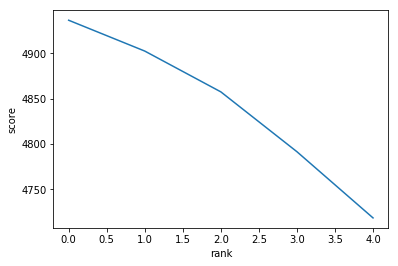

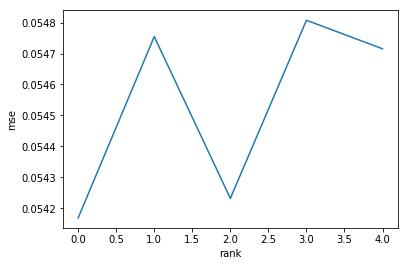

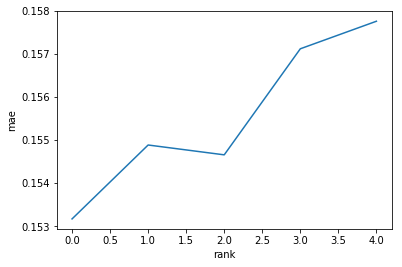

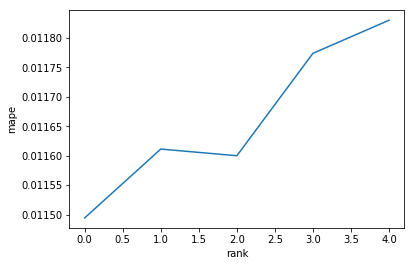

In [80]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

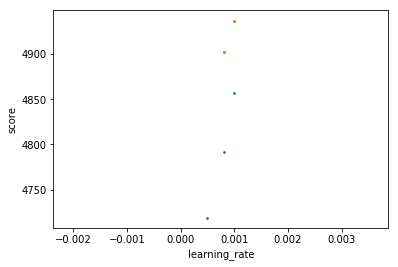

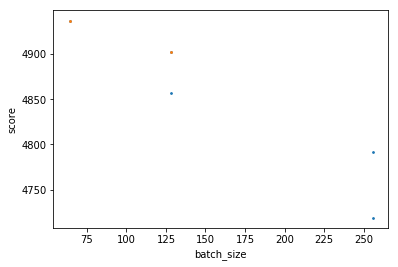

In [87]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

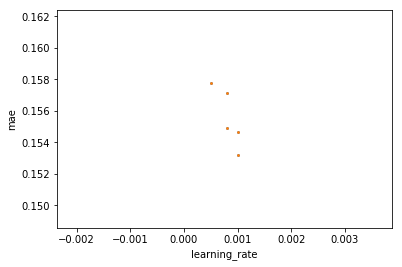

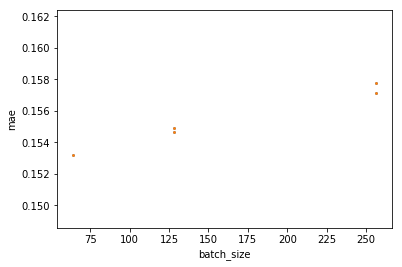

In [82]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

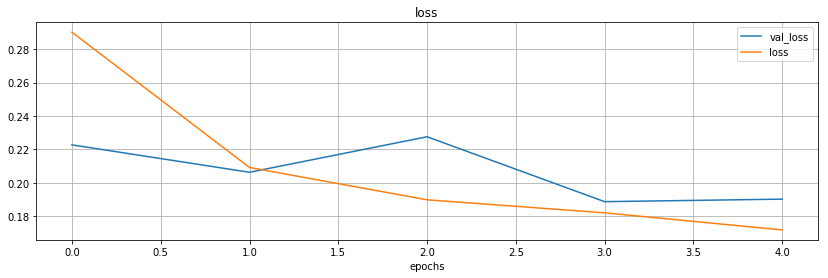

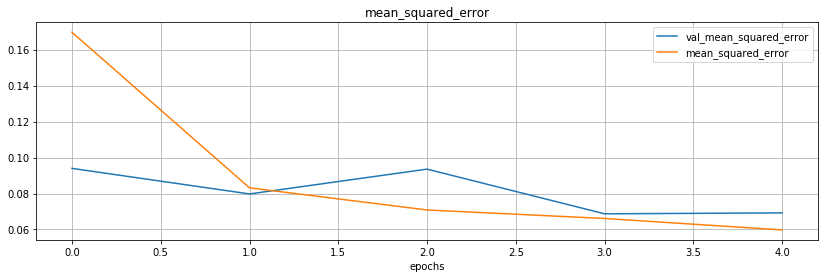

In [83]:
plot_keras_hist(hist)

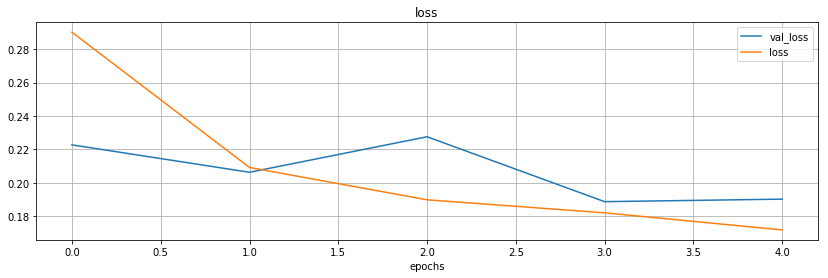

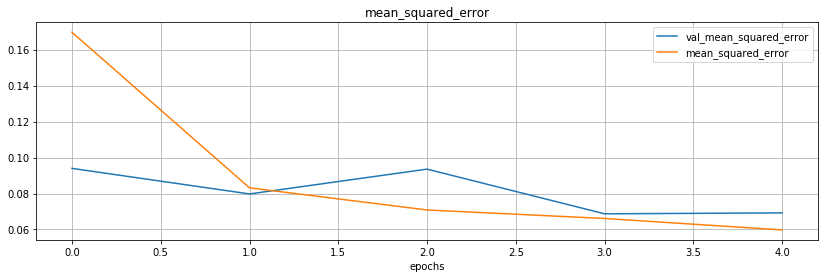

In [84]:
plot_keras_hist(gsearch_results[0][5][0])

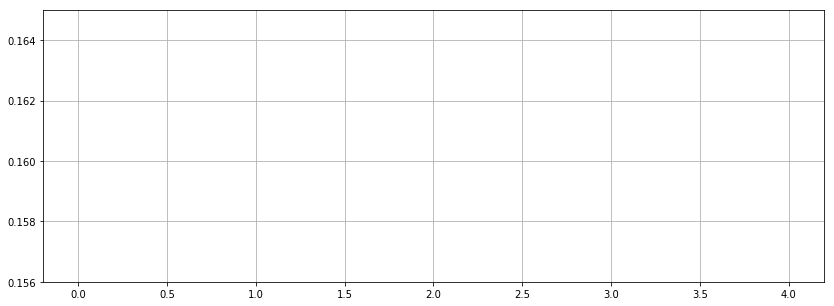

In [85]:
plt.figure(figsize=(14, 5))
for hist in gsearch_results[0][5]:
    plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

#### Round 2

In [100]:
params_fix = {'epochs': 200,
              'n_neurons': (1024,)*5+(512,)*5,
              'optimizer': Adam,
              'learning_rate': 0.001,              
             }

In [101]:
params_gsearch = {'batch_size': [64],}
N_fold = 3
N_iter = 1
score_low_bound = 4700 # if score smaller than this, skip the param set

In [102]:
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [103]:
rand_params_set

[{'batch_size': 64}]

In [104]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain].reset_index(drop=True)
    df_val = df.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                            n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                            optimizer=params['optimizer'])

        hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=2,
                         validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 211, 'village': 2781, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Train on 40000 samples, validate on 20000 samples
Epoch 1/200
 - 50s - loss: 0.2775 - mean_squared_error: 0.1450 - val_loss: 0.2398 - val_mean_squared_error: 0.1046
Epoch 2/200
 - 52s - loss: 0.2171 - mean_squared_error: 0.0889 - val_loss: 0.2334 - val_mean_squared_error: 0.0963
Epoch 3/200
 - 52s - loss: 0.1983 - mean_squared_error: 0.0760 - val_loss: 0.2003 - val_mean_squared_error: 0.0753
Epoch 4/200
 - 50s - loss: 0.1800 - mean_squared_error: 0.0654 - val_loss: 0.1879 - val_mean_squared_error: 0.0696
Epoch 5/200
 - 52s - loss: 0.1745 - mean_squared_error: 0.0613 - val_loss: 0.1866 -

Epoch 68/200
 - 50s - loss: 0.0492 - mean_squared_error: 0.0076 - val_loss: 0.1596 - val_mean_squared_error: 0.0558
Epoch 69/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1602 - val_mean_squared_error: 0.0559
Epoch 70/200
 - 48s - loss: 0.0481 - mean_squared_error: 0.0073 - val_loss: 0.1620 - val_mean_squared_error: 0.0570
Epoch 71/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1607 - val_mean_squared_error: 0.0558
Epoch 72/200
 - 49s - loss: 0.0470 - mean_squared_error: 0.0070 - val_loss: 0.1611 - val_mean_squared_error: 0.0562
Epoch 73/200
 - 51s - loss: 0.0472 - mean_squared_error: 0.0076 - val_loss: 0.1595 - val_mean_squared_error: 0.0553
Epoch 74/200
 - 49s - loss: 0.0462 - mean_squared_error: 0.0067 - val_loss: 0.1610 - val_mean_squared_error: 0.0563
Epoch 75/200
 - 49s - loss: 0.0456 - mean_squared_error: 0.0067 - val_loss: 0.1609 - val_mean_squared_error: 0.0568
Epoch 76/200
 - 50s - loss: 0.0451 - mean_squared_error: 0.0064 - val_lo

Epoch 139/200
 - 55s - loss: 0.0312 - mean_squared_error: 0.0036 - val_loss: 0.1582 - val_mean_squared_error: 0.0552
Epoch 140/200
 - 55s - loss: 0.0294 - mean_squared_error: 0.0040 - val_loss: 0.1594 - val_mean_squared_error: 0.0562
Epoch 141/200
 - 65s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1592 - val_mean_squared_error: 0.0554
Epoch 142/200
 - 60s - loss: 0.0306 - mean_squared_error: 0.0107 - val_loss: 0.1589 - val_mean_squared_error: 0.0559
Epoch 143/200
 - 53s - loss: 0.0301 - mean_squared_error: 0.0034 - val_loss: 0.1593 - val_mean_squared_error: 0.0558
Epoch 144/200
 - 58s - loss: 0.0298 - mean_squared_error: 0.0033 - val_loss: 0.1587 - val_mean_squared_error: 0.0555
Epoch 145/200
 - 52s - loss: 0.0288 - mean_squared_error: 0.0031 - val_loss: 0.1578 - val_mean_squared_error: 0.0553
Epoch 146/200
 - 49s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1578 - val_mean_squared_error: 0.0550
Epoch 147/200
 - 52s - loss: 0.0295 - mean_squared_error: 0.0032

 - 46s - loss: 0.1945 - mean_squared_error: 0.0729 - val_loss: 0.2105 - val_mean_squared_error: 0.0841
Epoch 4/200
 - 47s - loss: 0.1823 - mean_squared_error: 0.0658 - val_loss: 0.1933 - val_mean_squared_error: 0.0726
Epoch 5/200
 - 46s - loss: 0.1740 - mean_squared_error: 0.0607 - val_loss: 0.1913 - val_mean_squared_error: 0.0723
Epoch 6/200
 - 46s - loss: 0.1675 - mean_squared_error: 0.0568 - val_loss: 0.1876 - val_mean_squared_error: 0.0719
Epoch 7/200
 - 46s - loss: 0.1599 - mean_squared_error: 0.0528 - val_loss: 0.1812 - val_mean_squared_error: 0.0668
Epoch 8/200
 - 46s - loss: 0.1553 - mean_squared_error: 0.0497 - val_loss: 0.1900 - val_mean_squared_error: 0.0709
Epoch 9/200
 - 46s - loss: 0.1490 - mean_squared_error: 0.0462 - val_loss: 0.1720 - val_mean_squared_error: 0.0621
Epoch 10/200
 - 46s - loss: 0.1444 - mean_squared_error: 0.0441 - val_loss: 0.1837 - val_mean_squared_error: 0.0676
Epoch 11/200
 - 46s - loss: 0.1392 - mean_squared_error: 0.0414 - val_loss: 0.1710 - val_me

Epoch 74/200
 - 46s - loss: 0.0473 - mean_squared_error: 0.0069 - val_loss: 0.1601 - val_mean_squared_error: 0.0574
Epoch 75/200
 - 46s - loss: 0.0472 - mean_squared_error: 0.0068 - val_loss: 0.1598 - val_mean_squared_error: 0.0573
Epoch 76/200
 - 46s - loss: 0.0459 - mean_squared_error: 0.0065 - val_loss: 0.1596 - val_mean_squared_error: 0.0575
Epoch 77/200
 - 46s - loss: 0.0457 - mean_squared_error: 0.0065 - val_loss: 0.1607 - val_mean_squared_error: 0.0577
Epoch 78/200
 - 46s - loss: 0.0455 - mean_squared_error: 0.0063 - val_loss: 0.1591 - val_mean_squared_error: 0.0566
Epoch 79/200
 - 46s - loss: 0.0443 - mean_squared_error: 0.0061 - val_loss: 0.1598 - val_mean_squared_error: 0.0569
Epoch 80/200
 - 46s - loss: 0.0449 - mean_squared_error: 0.0062 - val_loss: 0.1596 - val_mean_squared_error: 0.0573
Epoch 81/200
 - 45s - loss: 0.0439 - mean_squared_error: 0.0060 - val_loss: 0.1600 - val_mean_squared_error: 0.0573
Epoch 82/200
 - 47s - loss: 0.0435 - mean_squared_error: 0.0059 - val_lo

Epoch 145/200
 - 46s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1582 - val_mean_squared_error: 0.0568
Epoch 146/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1572 - val_mean_squared_error: 0.0562
Epoch 147/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1588 - val_mean_squared_error: 0.0574
Epoch 148/200
 - 46s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1579 - val_mean_squared_error: 0.0567
Epoch 149/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0032 - val_loss: 0.1567 - val_mean_squared_error: 0.0561
Epoch 150/200
 - 47s - loss: 0.0292 - mean_squared_error: 0.0031 - val_loss: 0.1574 - val_mean_squared_error: 0.0563
Epoch 151/200
 - 46s - loss: 0.0284 - mean_squared_error: 0.0031 - val_loss: 0.1575 - val_mean_squared_error: 0.0564
Epoch 152/200
 - 46s - loss: 0.0289 - mean_squared_error: 0.0031 - val_loss: 0.1587 - val_mean_squared_error: 0.0574
Epoch 153/200
 - 46s - loss: 0.0293 - mean_squared_error: 0.0030

Epoch 10/200
 - 46s - loss: 0.1433 - mean_squared_error: 0.0433 - val_loss: 0.1725 - val_mean_squared_error: 0.0634
Epoch 11/200
 - 46s - loss: 0.1393 - mean_squared_error: 0.0410 - val_loss: 0.1719 - val_mean_squared_error: 0.0632
Epoch 12/200
 - 47s - loss: 0.1350 - mean_squared_error: 0.0390 - val_loss: 0.1827 - val_mean_squared_error: 0.0685
Epoch 13/200
 - 47s - loss: 0.1315 - mean_squared_error: 0.0372 - val_loss: 0.1700 - val_mean_squared_error: 0.0621
Epoch 14/200
 - 47s - loss: 0.1268 - mean_squared_error: 0.0351 - val_loss: 0.1740 - val_mean_squared_error: 0.0635
Epoch 15/200
 - 46s - loss: 0.1235 - mean_squared_error: 0.0338 - val_loss: 0.1724 - val_mean_squared_error: 0.0629
Epoch 16/200
 - 46s - loss: 0.1191 - mean_squared_error: 0.0316 - val_loss: 0.1808 - val_mean_squared_error: 0.0686
Epoch 17/200
 - 47s - loss: 0.1166 - mean_squared_error: 0.0304 - val_loss: 0.1737 - val_mean_squared_error: 0.0652
Epoch 18/200
 - 47s - loss: 0.1134 - mean_squared_error: 0.0292 - val_lo

Epoch 81/200
 - 48s - loss: 0.0440 - mean_squared_error: 0.0058 - val_loss: 0.1604 - val_mean_squared_error: 0.0586
Epoch 82/200
 - 47s - loss: 0.0427 - mean_squared_error: 0.0059 - val_loss: 0.1590 - val_mean_squared_error: 0.0589
Epoch 83/200
 - 48s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.1599 - val_mean_squared_error: 0.0588
Epoch 84/200
 - 47s - loss: 0.0426 - mean_squared_error: 0.0054 - val_loss: 0.1597 - val_mean_squared_error: 0.0587
Epoch 85/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0054 - val_loss: 0.1603 - val_mean_squared_error: 0.0589
Epoch 86/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0053 - val_loss: 0.1595 - val_mean_squared_error: 0.0588
Epoch 87/200
 - 47s - loss: 0.0421 - mean_squared_error: 0.0064 - val_loss: 0.1606 - val_mean_squared_error: 0.0596
Epoch 88/200
 - 47s - loss: 0.0413 - mean_squared_error: 0.0051 - val_loss: 0.1585 - val_mean_squared_error: 0.0580
Epoch 89/200
 - 47s - loss: 0.0408 - mean_squared_error: 0.0050 - val_lo

Epoch 152/200
 - 46s - loss: 0.0299 - mean_squared_error: 0.0030 - val_loss: 0.1576 - val_mean_squared_error: 0.0579
Epoch 153/200
 - 47s - loss: 0.0305 - mean_squared_error: 0.0031 - val_loss: 0.1569 - val_mean_squared_error: 0.0577
Epoch 154/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1570 - val_mean_squared_error: 0.0577
Epoch 155/200
 - 47s - loss: 0.0309 - mean_squared_error: 0.0032 - val_loss: 0.1577 - val_mean_squared_error: 0.0582
Epoch 156/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1580 - val_mean_squared_error: 0.0580
Epoch 157/200
 - 46s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1572 - val_mean_squared_error: 0.0574
Epoch 158/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0031 - val_loss: 0.1576 - val_mean_squared_error: 0.0581
Epoch 159/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1575 - val_mean_squared_error: 0.0577
Epoch 160/200
 - 46s - loss: 0.0309 - mean_squared_error: 0.0031

In [105]:
print('Total computing time:', t1-t0)

Total computing time: 28579.714686870575


In [106]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]


In [107]:
metrics = ['score', 'mse', 'mae', 'mape']

In [108]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics]
display(df_gsearch_results)

,batch_size,score,mse,mae,mape
0,64,5010.503402,0.052174,0.150916,0.011325


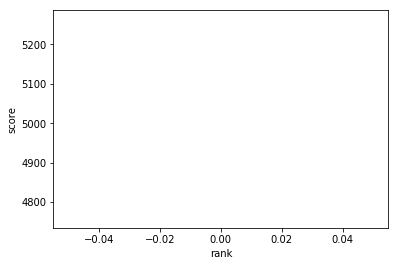

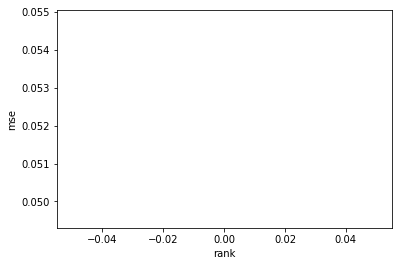

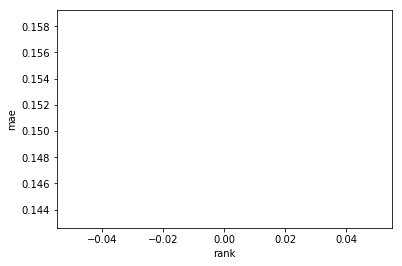

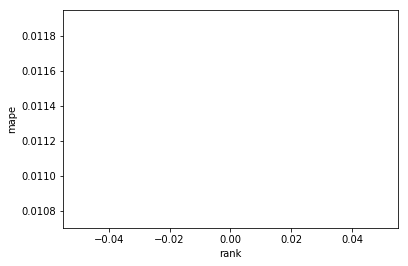

In [109]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

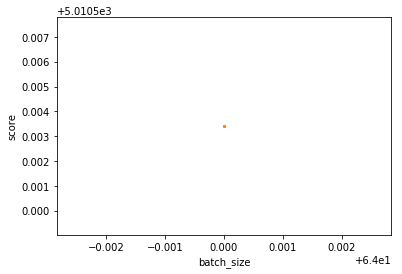

In [110]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

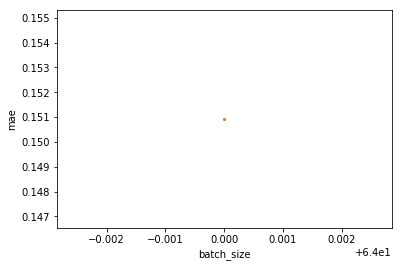

In [111]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

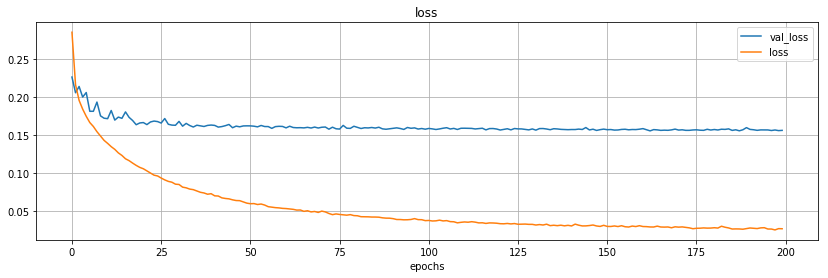

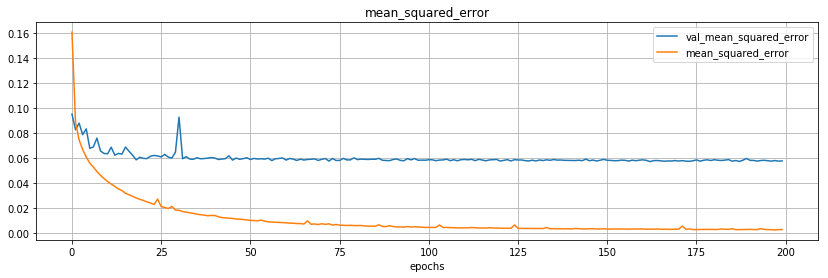

In [112]:
plot_keras_hist(hist)

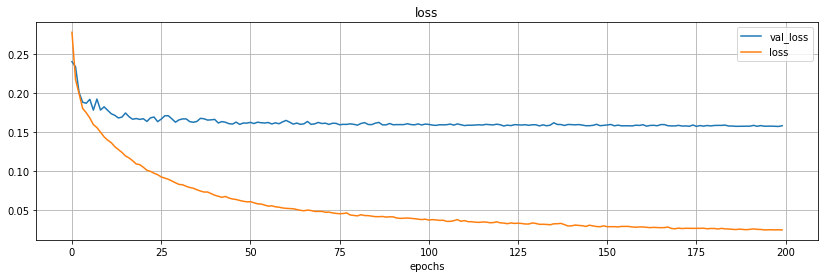

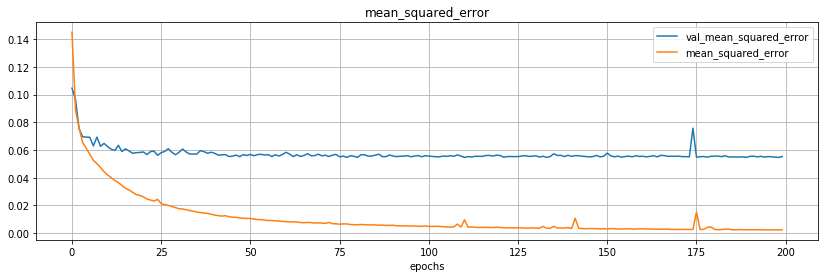

In [113]:
plot_keras_hist(gsearch_results[0][5][0])

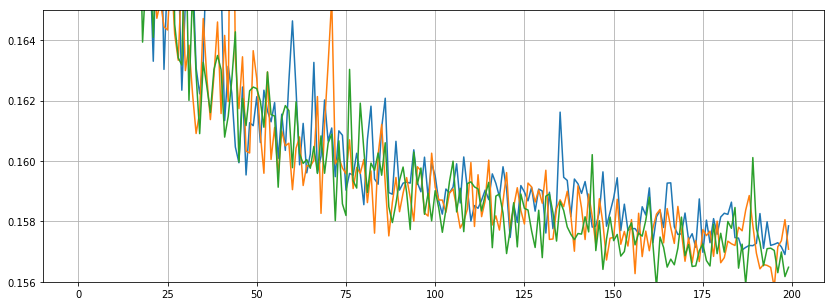

In [114]:
plt.figure(figsize=(14, 5))
for hist in gsearch_results[0][5]:
    plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

### Result

Round 2:

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]

Round 1: 

(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 4936.5001237591105 0.054168496 0.15317458 0.011494316 [4880.839069649577, 4968.83789165318, 4959.823409974575] [0.05246833, 0.05461397, 0.05542319] [0.15345706, 0.15383308, 0.1522336] [0.011516981, 0.011535957, 0.011430012]  
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0008), ('batch_size', 128)) 4902.5009123335285 0.054754768 0.1548909 0.011611172 [4872.8393027335405, 4920.837021976709, 4913.826412290335] [0.053417027, 0.055927727, 0.054919556] [0.15506728, 0.15528797, 0.15431745] [0.01162971, 0.011635942, 0.011567864]  
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 128)) 4857.500111763676 0.054231703 0.1546625 0.011599835 [4812.838380217552, 4884.839696779847, 4874.822258293629] [0.052770227, 0.054369133, 0.05555574] [0.15476438, 0.15430678, 0.15491636] [0.0116037885, 0.011569585, 0.011626132]  
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0008), ('batch_size', 256)) 4791.496810580294 0.054807622 0.15712523 0.011773665 [4736.835256829858, 4820.838531911373, 4816.816642999649] [0.053222205, 0.05549223, 0.05570843] [0.15762872, 0.15728033, 0.15646665] [0.011823622, 0.0117749255, 0.01172245]  
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0005), ('batch_size', 256)) 4718.493094210823 0.0547153 0.1577649 0.011829801 [4724.833606645465, 4715.834586530924, 4714.811089456081] [0.052873407, 0.055682763, 0.05558974] [0.1572821, 0.15798627, 0.1580263] [0.011801789, 0.011837361, 0.011850253]  